In [1]:
# IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import my_pickle as mp
import my_resample as ms
import my_functions as mf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score

from sklearn.ensemble.partial_dependence import plot_partial_dependence
# from sklearn.model_selection import GridSearchCV

# from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
# from scipy import interp
# from random import *
# import matplotlib.pyplot as plt
# %matplotlib inline

# from sklearn.ensemble.partial_dependence import plot_partial_dependence
# from sklearn.ensemble.partial_dependence import partial_dependence

from importlib import reload

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV

In [2]:
X = mp.unjson_it('data_X')
y = mp.unjson_it('data_y')['response']
text_similarity_df = mp.unjson_it('data_text_similarity')
X['count_similarity'] = text_similarity_df['count_similarity']
X['tfidf_similarity'] = text_similarity_df['tfidf_similarity']

In [3]:
def display_importances_trees():
    # show feature importances
    feature_df = pd.DataFrame([X.columns, model.feature_importances_]).T
    feature_df.columns = ['feature','value']
    return feature_df.sort_values('value', ascending=False)
             
def display_metrics():
    print("\nMETRICS")
    print("Model recall: {}".format(recall_score(y_test, y_pred)))
    print("Model precision: {}".format(precision_score(y_test, y_pred)))
    print("Model accuracy: {}".format(model.score(X_test, y_test)))

    print ("\nCONFUSION MATRIX")
    print (confusion_matrix(y_test, y_pred))
    print ("\nkey:")
    print (" TN   FP ")
    print (" FN   TP ")

    print("\nRECALL AND ACCURACY FOR DIFFERNET MODELS")
    print("recall     \t precision   \tmodel")
    print(recall_score(y_test, y_pred), '\t',precision_score(y_test, y_pred), "my model")
    print(recall_score(y_test, pred_all_0),'\t','\t', precision_score(y_test, pred_all_0), "\t\tpredict all zero")
    print(recall_score(y_test, pred_all_1),'\t','\t', precision_score(y_test, pred_all_1), "predict all one")
    print(recall_score(y_test, pred_50_50),'\t', precision_score(y_test, pred_50_50), "predict 50-50")
    print(recall_score(y_test, pred_90_10), precision_score(y_test, pred_90_10), "predict 90-10")

In [16]:
def fn_to_search(X, y, resample_wt=.5, learning_rate = .1):
    # train test split
    X_train, X_test, y_train, y_test = train_test_split(X.as_matrix(), y.as_matrix(), random_state=17)

    # resample
    X_train, y_train = ms.oversample(X_train, y_train, resample_wt)

    # scale data
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    model = GradientBoostingClassifier(learning_rate=learning_rate)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)

    f1 = (recall*precision)/(recall + precision)
    print("resample_wt: {:.2},   learning_rate: {:.2},   f1: {:.3},   recall: {:.3},   precision: {:.3}".format(resample_wt,learning_rate,f1,recall,precision))
           
    return f1

for learning_rate in np.arange(.01,.2,.01):
    fn_to_search(X, y, .5, learning_rate)
    
print("DONE!")

resample_wt: 0.5,   learning_rate: 0.01,   f1: 0.134,   recall: 0.618,   precision: 0.171
resample_wt: 0.5,   learning_rate: 0.02,   f1: 0.139,   recall: 0.611,   precision: 0.181
resample_wt: 0.5,   learning_rate: 0.03,   f1: 0.143,   recall: 0.601,   precision: 0.188
resample_wt: 0.5,   learning_rate: 0.04,   f1: 0.15,   recall: 0.621,   precision: 0.198
resample_wt: 0.5,   learning_rate: 0.05,   f1: 0.146,   recall: 0.577,   precision: 0.196
resample_wt: 0.5,   learning_rate: 0.06,   f1: 0.151,   recall: 0.594,   precision: 0.202
resample_wt: 0.5,   learning_rate: 0.07,   f1: 0.148,   recall: 0.567,   precision: 0.2
resample_wt: 0.5,   learning_rate: 0.08,   f1: 0.153,   recall: 0.567,   precision: 0.209
resample_wt: 0.5,   learning_rate: 0.09,   f1: 0.155,   recall: 0.573,   precision: 0.213
resample_wt: 0.5,   learning_rate: 0.1,   f1: 0.157,   recall: 0.567,   precision: 0.217
resample_wt: 0.5,   learning_rate: 0.11,   f1: 0.155,   recall: 0.546,   precision: 0.216
resample_wt: 0

In [ ]:
#     GBC_grid = {
#                 # 'loss' : ['deviance', 'exponential'],
#                 'learning_rate': [.1,.4,.8],
#                 'n_estimators': [100],
#                 'max_depth': [3,5,10],
#                 # 'criterion': ['friedman_mse','mse','mae'],
#                 'min_samples_split': [.2,.7,2,3],
#                 'min_samples_leaf': [1,2,3],
#                 'subsample': [.2,.5,1],
#                 # 'max_features': ['auto','sqrt','log2',None]
#                 }
    
GBC_grid = {'learning_rate': [.1,.4,.8]}

In [ ]:
def do_grid_search(X, y):
    '''
    X as 2d numpy array
    y as 1d numpy array
    
    PARAMETERS
    n_estimators: The number of trees in the forest
    criterion: gini or entropy
    max_features: The number of features to consider when looking for the best split
        If int, then consider max_features features at each split.
        If float, then max_features is a percentage and int(max_features * n_features) features are considered at each split.
        If “auto”, then max_features=sqrt(n_features).
        If “sqrt”, then max_features=sqrt(n_features) (same as “auto”).
        If “log2”, then max_features=log2(n_features).
        If None, then max_features=n_features.
    max_depth: The maximum depth of the tree
    n_jobs: The number of jobs to run in parallel for both fit and predict. If -1, then the number of jobs is set to the number of cores.
    '''
    
    # Split it up into our training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    # resample
    X_train, y_train = ms.oversample(X_train.as_matrix(), y_train.as_matrix(), .5)
    
    # Initalize our model here
    model = RandomForestClassifier()

    # Here are the params we are tuning
    param_grid = {'max_features' : [None],
                  'n_estimators' : [50,100,1000],
                  'max_depth': [50],
                  'min_samples_leaf': [3]
                  }

    # Plug in our model, params dict, and the number of jobs, then .fit()
    gs_cv = GridSearchCV(model, param_grid,scoring='f1', n_jobs=-1).fit(X_train, y_train)

    # return the best score and the best params
    return gs_cv.best_score_, gs_cv.best_params_

In [3]:
import matplotlib.pyplot as plt

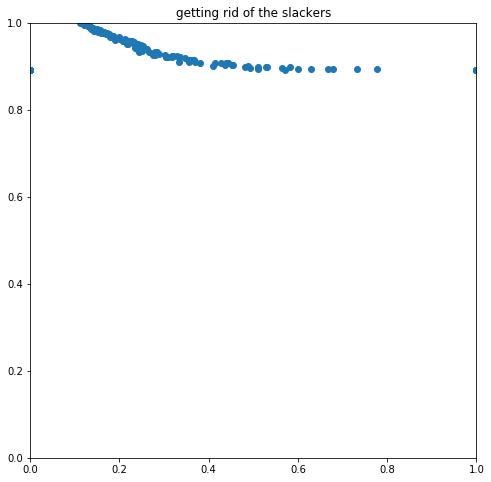

In [7]:
recall = [0.0,             0.0,                 0.0,                 0.089466089466089471, 0.21645021645021645, 0.37085137085137088, 0.44155844155844154, 0.52813852813852813, 0.69985569985569984, 0.85137085137085133, 0.92207792207792205, 0.94805194805194803, 0.97113997113997119, 0.99278499278499277, 1.0,  0.0, 0.0, 0.033189033189033192, 0.12121212121212122, 0.27417027417027418, 0.38816738816738816, 0.4704184704184704, 0.57431457431457433, 0.74458874458874458, 0.8614718614718615, 0.911976911976912, 0.92929292929292928, 0.9494949494949495, 0.98701298701298701, 0.99567099567099571, 1.0, 0.0, 0.001443001443001443, 0.047619047619047616, 0.17316017316017315, 0.26839826839826841, 0.37662337662337664, 0.49639249639249639, 0.6176046176046176, 0.74170274170274175, 0.82828282828282829, 0.89754689754689754, 0.92496392496392499, 0.94516594516594521, 0.97113997113997119, 0.98989898989898994, 0.99567099567099571, 0.0, 0.005772005772005772, 0.073593073593073599, 0.18037518037518038, 0.27849927849927852, 0.37518037518037517, 0.48917748917748916, 0.65512265512265511, 0.75180375180375181, 0.82972582972582976, 0.89033189033189031, 0.92063492063492058, 0.9408369408369408, 0.96392496392496396, 0.98268398268398272, 0.9913419913419913, 0.001443001443001443, 0.005772005772005772, 0.07647907647907648, 0.19336219336219337, 0.27849927849927852, 0.38383838383838381, 0.49927849927849927, 0.64357864357864358, 0.74603174603174605, 0.80952380952380953, 0.86291486291486297, 0.90764790764790759, 0.92929292929292928, 0.95959595959595956, 0.97113997113997119, 0.98845598845598848, 0.002886002886002886, 0.031746031746031744, 0.082251082251082255, 0.17027417027417027, 0.26406926406926406, 0.38383838383838381, 0.46897546897546899, 0.61327561327561331, 0.72150072150072153, 0.79653679653679654, 0.83405483405483405, 0.88167388167388172, 0.92207792207792205, 0.94516594516594521, 0.96392496392496396, 0.98124098124098125, 0.004329004329004329, 0.027417027417027416, 0.075036075036075039, 0.14285714285714285, 0.22077922077922077, 0.35786435786435788, 0.45310245310245312, 0.5670995670995671, 0.68109668109668109, 0.75180375180375181, 0.80808080808080807, 0.8528138528138528, 0.89177489177489178, 0.92352092352092352, 0.95238095238095233, 0.96681096681096679, 0.010101010101010102, 0.021645021645021644, 0.060606060606060608, 0.13564213564213565, 0.20057720057720058, 0.32178932178932179, 0.40836940836940838, 0.50505050505050508, 0.62481962481962483, 0.71572871572871577, 0.76046176046176051, 0.81962481962481959, 0.8571428571428571, 0.90043290043290047, 0.93939393939393945, 0.9538239538239538, 0.015873015873015872, 0.011544011544011544, 0.05772005772005772, 0.1111111111111111, 0.18326118326118326, 0.23809523809523808, 0.354978354978355, 0.43578643578643578, 0.53535353535353536, 0.6176046176046176, 0.70707070707070707, 0.7734487734487735, 0.80808080808080807, 0.85569985569985574, 0.911976911976912, 0.93362193362193358]
precision = [0.0,          0.0,                  0.0,                 0.48818897637795278, 0.36945812807881773, 0.31767614338689742, 0.27542754275427545, 0.24302788844621515, 0.21748878923766815, 0.18443263519849953, 0.1579337617399901, 0.14282608695652174, 0.13740302164148632, 0.12477330431628582, 0.11240875912408758, 0.0, 0.0, 0.51111111111111107, 0.45405405405405408, 0.3619047619047619, 0.32100238663484487, 0.2774468085106383, 0.24121212121212121, 0.21617092584834521, 0.18551895587321318, 0.16540172729651922, 0.15300546448087432, 0.14319912948857455, 0.13304804512740712, 0.12286324786324786, 0.11523112736947123, 0.0, 1.0, 0.4925373134328358, 0.44444444444444442, 0.36614173228346458, 0.30887573964497039, 0.27899432278994324, 0.24401368301026224, 0.21928327645051193, 0.1902552204176334, 0.17462099943851769, 0.15885997521685255, 0.14889747669924983, 0.13927980132450332, 0.1290929619872036, 0.1214574898785425, 0.0, 1.0, 0.51000000000000001, 0.42808219178082191, 0.3574074074074074, 0.30409356725146197, 0.28511354079058032, 0.24876712328767123, 0.22360515021459226, 0.19923769923769924, 0.17745182628702905, 0.16354780825429377, 0.1513814720222893, 0.14340918849291542, 0.1343990526939017, 0.12748190758953423, 1.0, 0.5714285714285714, 0.53000000000000003, 0.43934426229508194, 0.3541284403669725, 0.31856287425149699, 0.28107229894394803, 0.25283446712018143, 0.22815533980582525, 0.20050035739814154, 0.18519665531124188, 0.17143635868083948, 0.15846456692913385, 0.14947179141380085, 0.14006243496357962, 0.13015390461713852, 1.0, 0.62857142857142856, 0.52777777777777779, 0.44360902255639095, 0.3652694610778443, 0.32839506172839505, 0.28236316246741966, 0.2534287418008348, 0.23353573096683794, 0.21255294570658453, 0.19038208168642951, 0.17849839322231961, 0.16575875486381322, 0.15628728227153424, 0.14556548267596425, 0.13657360915846556, 1.0, 0.6785714285714286, 0.48148148148148145, 0.43612334801762115, 0.35581395348837208, 0.33513513513513515, 0.28940092165898618, 0.26095617529880477, 0.24143222506393863, 0.22029598308668077, 0.20187454938716654, 0.18643533123028391, 0.1753191489361702, 0.16280844568812008, 0.15256588072122051, 0.14108233312276269, 0.77777777777777779, 0.59999999999999998, 0.58333333333333337, 0.45192307692307693, 0.38082191780821917, 0.34681181959564539, 0.30332261521972131, 0.26555386949924126, 0.24827981651376146, 0.23102002794597112, 0.2086302454473476, 0.19867086393844002, 0.18271301138111351, 0.1702127659574468, 0.15924657534246575, 0.1489074115791845, 0.73333333333333328, 0.66666666666666663, 0.56338028169014087, 0.40957446808510639, 0.41503267973856212, 0.33468559837728196, 0.30521091811414391, 0.28014842300556586, 0.24983164983164982, 0.23477783872737246, 0.21894548704200179, 0.20775193798449612, 0.19002375296912113, 0.17818509615384615, 0.166447195154069, 0.1539010466222645]
NPV = [0.89230769230769236, 0.89230769230769236, 0.89230769230769236, 0.89996829422954983, 0.90993531265549843, 0.92250266619267685, 0.92731029301277235, 0.93365794278758374, 0.95053507728894171, 0.96817058096415332, 0.97739640016743412, 0.98038147138964582, 0.9869876382563435, 0.99457111834961998, 1.0, 0.89230769230769236, 0.89230769230769236, 0.89514866979655716, 0.90256000000000003, 0.91489001692047378, 0.92424513132035013, 0.93022813688212924, 0.93834900731452453, 0.95627470355731226, 0.97015853279452902, 0.97666411629686301, 0.9779874213836478, 0.98097826086956519, 0.99304482225656876, 0.99633699633699635, 1.0, 0.89230769230769236, 0.8924463786136152, 0.89635678391959794, 0.90705596107055964, 0.91445925426016539, 0.92271914132379251, 0.9329104190695886, 0.94338816492202526, 0.95624541676851627, 0.965184318314804, 0.97528715628263141, 0.97833333333333339, 0.98133595284872299, 0.98752339363693076, 0.99375557537912573, 0.99602122015915118, 0.89230769230769236, 0.89286269631472559, 0.89865824782951853, 0.90753703402246455, 0.91518235793044955, 0.92240143369175631, 0.93252001524971406, 0.94815618221258136, 0.95809987819732034, 0.96675119752042826, 0.97430696416497631, 0.97829518547750594, 0.98073308270676696, 0.9859313449634215, 0.99122807017543857, 0.99426386233269604, 0.8924463786136152, 0.89281269446172995, 0.89897395422257298, 0.90880913539967378, 0.91511035653650252, 0.92374999999999996, 0.93332052267486554, 0.94712053093555981, 0.95778364116094983, 0.96370635138850702, 0.97036805988771058, 0.97686189443239335, 0.97933361450864609, 0.98590130916414909, 0.98773006134969321, 0.99317406143344711, 0.89258510803668589, 0.89515624999999999, 0.89947842579421522, 0.90679202463932562, 0.91405460060667343, 0.92408888888888885, 0.93035579106737321, 0.94367381252627158, 0.95505356311131817, 0.96326211568525277, 0.96616651956457777, 0.97277556440903057, 0.97906976744186047, 0.98306595365418892, 0.98645720476706389, 0.9910714285714286, 0.89272388059701491, 0.89480255970032774, 0.8986881618460566, 0.90431701030927836, 0.91007493755203994, 0.92186128182616334, 0.92915887850467294, 0.93913572732805839, 0.95066964285714284, 0.95773955773955777, 0.96367112810707456, 0.96875957120980094, 0.97422680412371132, 0.97883386581469645, 0.98435277382645803, 0.98635824436536179, 0.89324618736383443, 0.8942277691107644, 0.89768976897689767, 0.90380600610245709, 0.90873146622734757, 0.91885359116022103, 0.92548164303889491, 0.93296853625170995, 0.94457471754423361, 0.95405783582089554, 0.95753389613711948, 0.96504474272930652, 0.96890703517587939, 0.97508125677139756, 0.98210481465700894, 0.98396793587174347, 0.89376947040498445, 0.8933520161918107, 0.89739157762413579, 0.90139266848087085, 0.90765214553760809, 0.91114102995624369, 0.92058980280689284, 0.92701138697031926, 0.93494949494949497, 0.94254119687771032, 0.9516321181796521, 0.95927367055771728, 0.96186926605504586, 0.96781461216607656, 0.97687642153146326, 0.97938144329896903]

plt.figure(figsize=(8,8))
plt.scatter(precision, NPV)
plt.axis([0, 1, 0,1])
plt.title('getting rid of the slackers')
plt.show()

In [ ]:
resample_wt: 0.1, max_depth: 1, f1: nan,   rcll: 0.0,   prcsn: 0.0, NPV: 0.8923076923076924
resample_wt: 0.15000000000000002, max_depth: 1, f1: nan,   rcll: 0.0,   prcsn: 0.0, NPV: 0.8923076923076924
resample_wt: 0.20000000000000004, max_depth: 1, f1: nan,   rcll: 0.0,   prcsn: 0.0, NPV: 0.8923076923076924
resample_wt: 0.25000000000000006, max_depth: 1, f1: 0.0756,   rcll: 0.0895,   prcsn: 0.488, NPV: 0.8999682942295498
resample_wt: 0.30000000000000004, max_depth: 1, f1: 0.136,   rcll: 0.216,   prcsn: 0.369, NPV: 0.9099353126554984
resample_wt: 0.3500000000000001, max_depth: 1, f1: 0.171,   rcll: 0.371,   prcsn: 0.318, NPV: 0.9225026661926768
resample_wt: 0.40000000000000013, max_depth: 1, f1: 0.17,   rcll: 0.442,   prcsn: 0.275, NPV: 0.9273102930127723
resample_wt: 0.45000000000000007, max_depth: 1, f1: 0.166,   rcll: 0.528,   prcsn: 0.243, NPV: 0.9336579427875837
resample_wt: 0.5000000000000001, max_depth: 1, f1: 0.166,   rcll: 0.7,   prcsn: 0.217, NPV: 0.9505350772889417
resample_wt: 0.5500000000000002, max_depth: 1, f1: 0.152,   rcll: 0.851,   prcsn: 0.184, NPV: 0.9681705809641533
resample_wt: 0.6000000000000002, max_depth: 1, f1: 0.135,   rcll: 0.922,   prcsn: 0.158, NPV: 0.9773964001674341
resample_wt: 0.6500000000000001, max_depth: 1, f1: 0.124,   rcll: 0.948,   prcsn: 0.143, NPV: 0.9803814713896458
resample_wt: 0.7000000000000002, max_depth: 1, f1: 0.12,   rcll: 0.971,   prcsn: 0.137, NPV: 0.9869876382563435
resample_wt: 0.7500000000000002, max_depth: 1, f1: 0.111,   rcll: 0.993,   prcsn: 0.125, NPV: 0.99457111834962
resample_wt: 0.8000000000000002, max_depth: 1, f1: 0.101,   rcll: 1.0,   prcsn: 0.112, NPV: 1.0
gridsearch_interact.py:68: RuntimeWarning: invalid value encountered in long_scalars
  return TN/(TN+FN)
resample_wt: 0.8500000000000002, max_depth: 1, f1: 0.0972,   rcll: 1.0,   prcsn: 0.108, NPV: nan
resample_wt: 0.1, max_depth: 2, f1: nan,   rcll: 0.0,   prcsn: 0.0, NPV: 0.8923076923076924
resample_wt: 0.15000000000000002, max_depth: 2, f1: nan,   rcll: 0.0,   prcsn: 0.0, NPV: 0.8923076923076924
resample_wt: 0.20000000000000004, max_depth: 2, f1: 0.0312,   rcll: 0.0332,   prcsn: 0.511, NPV: 0.8951486697965572
resample_wt: 0.25000000000000006, max_depth: 2, f1: 0.0957,   rcll: 0.121,   prcsn: 0.454, NPV: 0.90256
resample_wt: 0.30000000000000004, max_depth: 2, f1: 0.156,   rcll: 0.274,   prcsn: 0.362, NPV: 0.9148900169204738
resample_wt: 0.3500000000000001, max_depth: 2, f1: 0.176,   rcll: 0.388,   prcsn: 0.321, NPV: 0.9242451313203501
resample_wt: 0.40000000000000013, max_depth: 2, f1: 0.175,   rcll: 0.47,   prcsn: 0.277, NPV: 0.9302281368821292
resample_wt: 0.45000000000000007, max_depth: 2, f1: 0.17,   rcll: 0.574,   prcsn: 0.241, NPV: 0.9383490073145245
resample_wt: 0.5000000000000001, max_depth: 2, f1: 0.168,   rcll: 0.745,   prcsn: 0.216, NPV: 0.9562747035573123
resample_wt: 0.5500000000000002, max_depth: 2, f1: 0.153,   rcll: 0.861,   prcsn: 0.186, NPV: 0.970158532794529
resample_wt: 0.6000000000000002, max_depth: 2, f1: 0.14,   rcll: 0.912,   prcsn: 0.165, NPV: 0.976664116296863
resample_wt: 0.6500000000000001, max_depth: 2, f1: 0.131,   rcll: 0.929,   prcsn: 0.153, NPV: 0.9779874213836478
resample_wt: 0.7000000000000002, max_depth: 2, f1: 0.124,   rcll: 0.949,   prcsn: 0.143, NPV: 0.9809782608695652
resample_wt: 0.7500000000000002, max_depth: 2, f1: 0.117,   rcll: 0.987,   prcsn: 0.133, NPV: 0.9930448222565688
resample_wt: 0.8000000000000002, max_depth: 2, f1: 0.109,   rcll: 0.996,   prcsn: 0.123, NPV: 0.9963369963369964
resample_wt: 0.8500000000000002, max_depth: 2, f1: 0.103,   rcll: 1.0,   prcsn: 0.115, NPV: 1.0
resample_wt: 0.1, max_depth: 3, f1: nan,   rcll: 0.0,   prcsn: 0.0, NPV: 0.8923076923076924
resample_wt: 0.15000000000000002, max_depth: 3, f1: 0.00144,   rcll: 0.00144,   prcsn: 1.0, NPV: 0.8924463786136152
resample_wt: 0.20000000000000004, max_depth: 3, f1: 0.0434,   rcll: 0.0476,   prcsn: 0.493, NPV: 0.8963567839195979
resample_wt: 0.25000000000000006, max_depth: 3, f1: 0.125,   rcll: 0.173,   prcsn: 0.444, NPV: 0.9070559610705596
resample_wt: 0.30000000000000004, max_depth: 3, f1: 0.155,   rcll: 0.268,   prcsn: 0.366, NPV: 0.9144592542601654
resample_wt: 0.3500000000000001, max_depth: 3, f1: 0.17,   rcll: 0.377,   prcsn: 0.309, NPV: 0.9227191413237925
resample_wt: 0.40000000000000013, max_depth: 3, f1: 0.179,   rcll: 0.496,   prcsn: 0.279, NPV: 0.9329104190695886
resample_wt: 0.45000000000000007, max_depth: 3, f1: 0.175,   rcll: 0.618,   prcsn: 0.244, NPV: 0.9433881649220253
resample_wt: 0.5000000000000001, max_depth: 3, f1: 0.169,   rcll: 0.742,   prcsn: 0.219, NPV: 0.9562454167685163
resample_wt: 0.5500000000000002, max_depth: 3, f1: 0.155,   rcll: 0.828,   prcsn: 0.19, NPV: 0.965184318314804
resample_wt: 0.6000000000000002, max_depth: 3, f1: 0.146,   rcll: 0.898,   prcsn: 0.175, NPV: 0.9752871562826314
resample_wt: 0.6500000000000001, max_depth: 3, f1: 0.136,   rcll: 0.925,   prcsn: 0.159, NPV: 0.9783333333333334
resample_wt: 0.7000000000000002, max_depth: 3, f1: 0.129,   rcll: 0.945,   prcsn: 0.149, NPV: 0.981335952848723
resample_wt: 0.7500000000000002, max_depth: 3, f1: 0.122,   rcll: 0.971,   prcsn: 0.139, NPV: 0.9875233936369308
resample_wt: 0.8000000000000002, max_depth: 3, f1: 0.114,   rcll: 0.99,   prcsn: 0.129, NPV: 0.9937555753791257
resample_wt: 0.8500000000000002, max_depth: 3, f1: 0.108,   rcll: 0.996,   prcsn: 0.121, NPV: 0.9960212201591512
resample_wt: 0.1, max_depth: 4, f1: nan,   rcll: 0.0,   prcsn: 0.0, NPV: 0.8923076923076924
resample_wt: 0.15000000000000002, max_depth: 4, f1: 0.00574,   rcll: 0.00577,   prcsn: 1.0, NPV: 0.8928626963147256
resample_wt: 0.20000000000000004, max_depth: 4, f1: 0.0643,   rcll: 0.0736,   prcsn: 0.51, NPV: 0.8986582478295185
resample_wt: 0.25000000000000006, max_depth: 4, f1: 0.127,   rcll: 0.18,   prcsn: 0.428, NPV: 0.9075370340224646
resample_wt: 0.30000000000000004, max_depth: 4, f1: 0.157,   rcll: 0.278,   prcsn: 0.357, NPV: 0.9151823579304496
resample_wt: 0.3500000000000001, max_depth: 4, f1: 0.168,   rcll: 0.375,   prcsn: 0.304, NPV: 0.9224014336917563
resample_wt: 0.40000000000000013, max_depth: 4, f1: 0.18,   rcll: 0.489,   prcsn: 0.285, NPV: 0.9325200152497141
resample_wt: 0.45000000000000007, max_depth: 4, f1: 0.18,   rcll: 0.655,   prcsn: 0.249, NPV: 0.9481561822125814
resample_wt: 0.5000000000000001, max_depth: 4, f1: 0.172,   rcll: 0.752,   prcsn: 0.224, NPV: 0.9580998781973203
resample_wt: 0.5500000000000002, max_depth: 4, f1: 0.161,   rcll: 0.83,   prcsn: 0.199, NPV: 0.9667511975204283
resample_wt: 0.6000000000000002, max_depth: 4, f1: 0.148,   rcll: 0.89,   prcsn: 0.177, NPV: 0.9743069641649763
resample_wt: 0.6500000000000001, max_depth: 4, f1: 0.139,   rcll: 0.921,   prcsn: 0.164, NPV: 0.9782951854775059
resample_wt: 0.7000000000000002, max_depth: 4, f1: 0.13,   rcll: 0.941,   prcsn: 0.151, NPV: 0.980733082706767
resample_wt: 0.7500000000000002, max_depth: 4, f1: 0.125,   rcll: 0.964,   prcsn: 0.143, NPV: 0.9859313449634215
resample_wt: 0.8000000000000002, max_depth: 4, f1: 0.118,   rcll: 0.983,   prcsn: 0.134, NPV: 0.9912280701754386
resample_wt: 0.8500000000000002, max_depth: 4, f1: 0.113,   rcll: 0.991,   prcsn: 0.127, NPV: 0.994263862332696
resample_wt: 0.1, max_depth: 5, f1: 0.00144,   rcll: 0.00144,   prcsn: 1.0, NPV: 0.8924463786136152
resample_wt: 0.15000000000000002, max_depth: 5, f1: 0.00571,   rcll: 0.00577,   prcsn: 0.571, NPV: 0.89281269446173
resample_wt: 0.20000000000000004, max_depth: 5, f1: 0.0668,   rcll: 0.0765,   prcsn: 0.53, NPV: 0.898973954222573
resample_wt: 0.25000000000000006, max_depth: 5, f1: 0.134,   rcll: 0.193,   prcsn: 0.439, NPV: 0.9088091353996738
resample_wt: 0.30000000000000004, max_depth: 5, f1: 0.156,   rcll: 0.278,   prcsn: 0.354, NPV: 0.9151103565365025
resample_wt: 0.3500000000000001, max_depth: 5, f1: 0.174,   rcll: 0.384,   prcsn: 0.319, NPV: 0.92375
resample_wt: 0.40000000000000013, max_depth: 5, f1: 0.18,   rcll: 0.499,   prcsn: 0.281, NPV: 0.9333205226748655
resample_wt: 0.45000000000000007, max_depth: 5, f1: 0.182,   rcll: 0.644,   prcsn: 0.253, NPV: 0.9471205309355598
resample_wt: 0.5000000000000001, max_depth: 5, f1: 0.175,   rcll: 0.746,   prcsn: 0.228, NPV: 0.9577836411609498
resample_wt: 0.5500000000000002, max_depth: 5, f1: 0.161,   rcll: 0.81,   prcsn: 0.201, NPV: 0.963706351388507
resample_wt: 0.6000000000000002, max_depth: 5, f1: 0.152,   rcll: 0.863,   prcsn: 0.185, NPV: 0.9703680598877106
resample_wt: 0.6500000000000001, max_depth: 5, f1: 0.144,   rcll: 0.908,   prcsn: 0.171, NPV: 0.9768618944323934
resample_wt: 0.7000000000000002, max_depth: 5, f1: 0.135,   rcll: 0.929,   prcsn: 0.158, NPV: 0.9793336145086461
resample_wt: 0.7500000000000002, max_depth: 5, f1: 0.129,   rcll: 0.96,   prcsn: 0.149, NPV: 0.9859013091641491
resample_wt: 0.8000000000000002, max_depth: 5, f1: 0.122,   rcll: 0.971,   prcsn: 0.14, NPV: 0.9877300613496932
resample_wt: 0.8500000000000002, max_depth: 5, f1: 0.115,   rcll: 0.988,   prcsn: 0.13, NPV: 0.9931740614334471
resample_wt: 0.1, max_depth: 6, f1: 0.00288,   rcll: 0.00289,   prcsn: 1.0, NPV: 0.8925851080366859
resample_wt: 0.15000000000000002, max_depth: 6, f1: 0.0302,   rcll: 0.0317,   prcsn: 0.629, NPV: 0.89515625
resample_wt: 0.20000000000000004, max_depth: 6, f1: 0.0712,   rcll: 0.0823,   prcsn: 0.528, NPV: 0.8994784257942152
resample_wt: 0.25000000000000006, max_depth: 6, f1: 0.123,   rcll: 0.17,   prcsn: 0.444, NPV: 0.9067920246393256
resample_wt: 0.30000000000000004, max_depth: 6, f1: 0.153,   rcll: 0.264,   prcsn: 0.365, NPV: 0.9140546006066734
resample_wt: 0.3500000000000001, max_depth: 6, f1: 0.177,   rcll: 0.384,   prcsn: 0.328, NPV: 0.9240888888888888
resample_wt: 0.40000000000000013, max_depth: 6, f1: 0.176,   rcll: 0.469,   prcsn: 0.282, NPV: 0.9303557910673732
resample_wt: 0.45000000000000007, max_depth: 6, f1: 0.179,   rcll: 0.613,   prcsn: 0.253, NPV: 0.9436738125262716
resample_wt: 0.5000000000000001, max_depth: 6, f1: 0.176,   rcll: 0.722,   prcsn: 0.234, NPV: 0.9550535631113182
resample_wt: 0.5500000000000002, max_depth: 6, f1: 0.168,   rcll: 0.797,   prcsn: 0.213, NPV: 0.9632621156852528
resample_wt: 0.6000000000000002, max_depth: 6, f1: 0.155,   rcll: 0.834,   prcsn: 0.19, NPV: 0.9661665195645778
resample_wt: 0.6500000000000001, max_depth: 6, f1: 0.148,   rcll: 0.882,   prcsn: 0.178, NPV: 0.9727755644090306
resample_wt: 0.7000000000000002, max_depth: 6, f1: 0.141,   rcll: 0.922,   prcsn: 0.166, NPV: 0.9790697674418605
resample_wt: 0.7500000000000002, max_depth: 6, f1: 0.134,   rcll: 0.945,   prcsn: 0.156, NPV: 0.9830659536541889
resample_wt: 0.8000000000000002, max_depth: 6, f1: 0.126,   rcll: 0.964,   prcsn: 0.146, NPV: 0.9864572047670639
resample_wt: 0.8500000000000002, max_depth: 6, f1: 0.12,   rcll: 0.981,   prcsn: 0.137, NPV: 0.9910714285714286
resample_wt: 0.1, max_depth: 7, f1: 0.00431,   rcll: 0.00433,   prcsn: 1.0, NPV: 0.8927238805970149
resample_wt: 0.15000000000000002, max_depth: 7, f1: 0.0264,   rcll: 0.0274,   prcsn: 0.679, NPV: 0.8948025597003277
resample_wt: 0.20000000000000004, max_depth: 7, f1: 0.0649,   rcll: 0.075,   prcsn: 0.481, NPV: 0.8986881618460566
resample_wt: 0.25000000000000006, max_depth: 7, f1: 0.108,   rcll: 0.143,   prcsn: 0.436, NPV: 0.9043170103092784
resample_wt: 0.30000000000000004, max_depth: 7, f1: 0.136,   rcll: 0.221,   prcsn: 0.356, NPV: 0.9100749375520399
resample_wt: 0.3500000000000001, max_depth: 7, f1: 0.173,   rcll: 0.358,   prcsn: 0.335, NPV: 0.9218612818261633
resample_wt: 0.40000000000000013, max_depth: 7, f1: 0.177,   rcll: 0.453,   prcsn: 0.289, NPV: 0.9291588785046729
resample_wt: 0.45000000000000007, max_depth: 7, f1: 0.179,   rcll: 0.567,   prcsn: 0.261, NPV: 0.9391357273280584
resample_wt: 0.5000000000000001, max_depth: 7, f1: 0.178,   rcll: 0.681,   prcsn: 0.241, NPV: 0.9506696428571428
resample_wt: 0.5500000000000002, max_depth: 7, f1: 0.17,   rcll: 0.752,   prcsn: 0.22, NPV: 0.9577395577395578
resample_wt: 0.6000000000000002, max_depth: 7, f1: 0.162,   rcll: 0.808,   prcsn: 0.202, NPV: 0.9636711281070746
resample_wt: 0.6500000000000001, max_depth: 7, f1: 0.153,   rcll: 0.853,   prcsn: 0.186, NPV: 0.9687595712098009
resample_wt: 0.7000000000000002, max_depth: 7, f1: 0.147,   rcll: 0.892,   prcsn: 0.175, NPV: 0.9742268041237113
resample_wt: 0.7500000000000002, max_depth: 7, f1: 0.138,   rcll: 0.924,   prcsn: 0.163, NPV: 0.9788338658146964
resample_wt: 0.8000000000000002, max_depth: 7, f1: 0.132,   rcll: 0.952,   prcsn: 0.153, NPV: 0.984352773826458
resample_wt: 0.8500000000000002, max_depth: 7, f1: 0.123,   rcll: 0.967,   prcsn: 0.141, NPV: 0.9863582443653618
resample_wt: 0.1, max_depth: 8, f1: 0.00997,   rcll: 0.0101,   prcsn: 0.778, NPV: 0.8932461873638344
resample_wt: 0.15000000000000002, max_depth: 8, f1: 0.0209,   rcll: 0.0216,   prcsn: 0.6, NPV: 0.8942277691107644
resample_wt: 0.20000000000000004, max_depth: 8, f1: 0.0549,   rcll: 0.0606,   prcsn: 0.583, NPV: 0.8976897689768977
resample_wt: 0.25000000000000006, max_depth: 8, f1: 0.104,   rcll: 0.136,   prcsn: 0.452, NPV: 0.9038060061024571
resample_wt: 0.30000000000000004, max_depth: 8, f1: 0.131,   rcll: 0.201,   prcsn: 0.381, NPV: 0.9087314662273476
resample_wt: 0.3500000000000001, max_depth: 8, f1: 0.167,   rcll: 0.322,   prcsn: 0.347, NPV: 0.918853591160221
resample_wt: 0.40000000000000013, max_depth: 8, f1: 0.174,   rcll: 0.408,   prcsn: 0.303, NPV: 0.9254816430388949
resample_wt: 0.45000000000000007, max_depth: 8, f1: 0.174,   rcll: 0.505,   prcsn: 0.266, NPV: 0.93296853625171
resample_wt: 0.5000000000000001, max_depth: 8, f1: 0.178,   rcll: 0.625,   prcsn: 0.248, NPV: 0.9445747175442336
resample_wt: 0.5500000000000002, max_depth: 8, f1: 0.175,   rcll: 0.716,   prcsn: 0.231, NPV: 0.9540578358208955
resample_wt: 0.6000000000000002, max_depth: 8, f1: 0.164,   rcll: 0.76,   prcsn: 0.209, NPV: 0.9575338961371195
resample_wt: 0.6500000000000001, max_depth: 8, f1: 0.16,   rcll: 0.82,   prcsn: 0.199, NPV: 0.9650447427293065
resample_wt: 0.7000000000000002, max_depth: 8, f1: 0.151,   rcll: 0.857,   prcsn: 0.183, NPV: 0.9689070351758794
resample_wt: 0.7500000000000002, max_depth: 8, f1: 0.143,   rcll: 0.9,   prcsn: 0.17, NPV: 0.9750812567713976
resample_wt: 0.8000000000000002, max_depth: 8, f1: 0.136,   rcll: 0.939,   prcsn: 0.159, NPV: 0.9821048146570089
resample_wt: 0.8500000000000002, max_depth: 8, f1: 0.129,   rcll: 0.954,   prcsn: 0.149, NPV: 0.9839679358717435
resample_wt: 0.1, max_depth: 9, f1: 0.0155,   rcll: 0.0159,   prcsn: 0.733, NPV: 0.8937694704049844
resample_wt: 0.15000000000000002, max_depth: 9, f1: 0.0113,   rcll: 0.0115,   prcsn: 0.667, NPV: 0.8933520161918107
resample_wt: 0.20000000000000004, max_depth: 9, f1: 0.0524,   rcll: 0.0577,   prcsn: 0.563, NPV: 0.8973915776241358
resample_wt: 0.25000000000000006, max_depth: 9, f1: 0.0874,   rcll: 0.111,   prcsn: 0.41, NPV: 0.9013926684808709
resample_wt: 0.30000000000000004, max_depth: 9, f1: 0.127,   rcll: 0.183,   prcsn: 0.415, NPV: 0.9076521455376081
resample_wt: 0.3500000000000001, max_depth: 9, f1: 0.139,   rcll: 0.238,   prcsn: 0.335, NPV: 0.9111410299562437
resample_wt: 0.40000000000000013, max_depth: 9, f1: 0.164,   rcll: 0.355,   prcsn: 0.305, NPV: 0.9205898028068928
resample_wt: 0.45000000000000007, max_depth: 9, f1: 0.171,   rcll: 0.436,   prcsn: 0.28, NPV: 0.9270113869703193
resample_wt: 0.5000000000000001, max_depth: 9, f1: 0.17,   rcll: 0.535,   prcsn: 0.25, NPV: 0.934949494949495
resample_wt: 0.5500000000000002, max_depth: 9, f1: 0.17,   rcll: 0.618,   prcsn: 0.235, NPV: 0.9425411968777103
resample_wt: 0.6000000000000002, max_depth: 9, f1: 0.167,   rcll: 0.707,   prcsn: 0.219, NPV: 0.9516321181796521
resample_wt: 0.6500000000000001, max_depth: 9, f1: 0.164,   rcll: 0.773,   prcsn: 0.208, NPV: 0.9592736705577173
resample_wt: 0.7000000000000002, max_depth: 9, f1: 0.154,   rcll: 0.808,   prcsn: 0.19, NPV: 0.9618692660550459
resample_wt: 0.7500000000000002, max_depth: 9, f1: 0.147,   rcll: 0.856,   prcsn: 0.178, NPV: 0.9678146121660766
resample_wt: 0.8000000000000002, max_depth: 9, f1: 0.141,   rcll: 0.912,   prcsn: 0.166, NPV: 0.9768764215314633
resample_wt: 0.8500000000000002, max_depth: 9, f1: 0.132,   rcll: 0.934,   prcsn: 0.154, NPV: 0.979381443298969

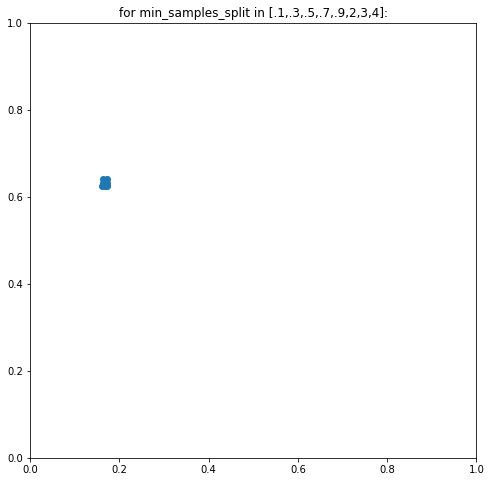

In [41]:
recall=[0.62457337883959041, 0.62798634812286691, 0.6313993174061433, 0.64163822525597269, 0.62457337883959041, 0.6313993174061433, 0.64163822525597269, 0.62457337883959041]
precision = [0.16697080291970803, 0.16927322907083717, 0.16400709219858156, 0.16333622936576889, 0.16024518388791595, 0.17161410018552875, 0.17184643510054845, 0.17296786389413987]

plt.figure(figsize=(8,8))
plt.scatter(precision, recall)
plt.axis([0, 1, 0,1])
plt.title('for min_samples_split in [.1,.3,.5,.7,.9,2,3,4]:')
plt.show()

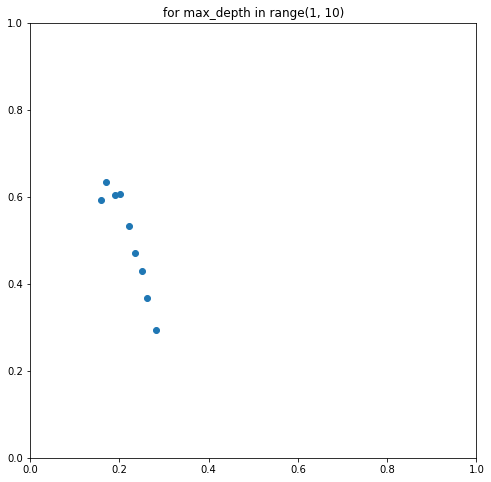

In [38]:
recall = [0.59385665529010234, 0.6348122866894198, 0.60409556313993173, 0.60750853242320824, 0.53242320819112632, 0.47098976109215018, 0.43003412969283278, 0.36860068259385664, 0.29351535836177473]
precision = [0.15934065934065933, 0.17064220183486239, 0.19011815252416756, 0.20227272727272727, 0.22159090909090909, 0.23509369676320271, 0.25099601593625498, 0.26277372262773724, 0.28104575163398693]

plt.figure(figsize=(8,8))
plt.scatter(precision, recall)
plt.axis([0, 1, 0,1])
plt.title('for max_depth in range(1, 10)')
plt.show()


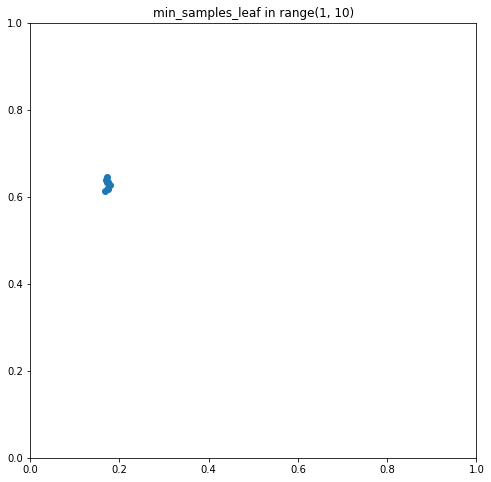

no effect


In [40]:
recall = [0.6348122866894198, 0.62116040955631402, 0.6450511945392492, 0.62798634812286691, 0.6348122866894198, 0.61774744027303752, 0.63822525597269619, 0.61433447098976113, 0.6348122866894198]
precision = [0.17366946778711484, 0.17366412213740459, 0.17276051188299818, 0.17916260954235638, 0.17238183503243745, 0.17353787152444872, 0.17046490428441202, 0.16869728209934395, 0.1733457595526561]

plt.figure(figsize=(8,8))
plt.scatter(precision, recall)
plt.axis([0, 1, 0,1])
plt.title('min_samples_leaf in range(1, 10)')
plt.show()

print("no effect")

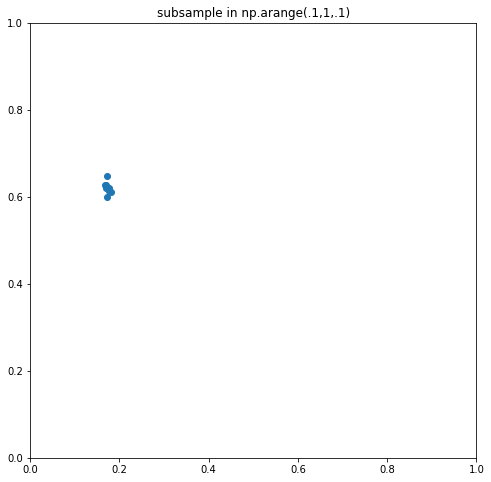

In [36]:
recall = [0.61433447098976113, 0.62798634812286691, 0.61092150170648463, 0.62798634812286691, 0.62116040955631402, 0.62116040955631402, 0.60068259385665534, 0.64846416382252559, 0.62116040955631402]
precision = [0.17751479289940827, 0.17100371747211895, 0.18062563067608475, 0.16681776971894832, 0.17105263157894737, 0.17756097560975609, 0.17221135029354206, 0.17148014440433212, 0.17432950191570881]
plt.figure(figsize=(8,8))
plt.scatter(precision, recall)
plt.axis([0, 1, 0,1])
plt.title('subsample in np.arange(.1,1,.1)')
plt.show()

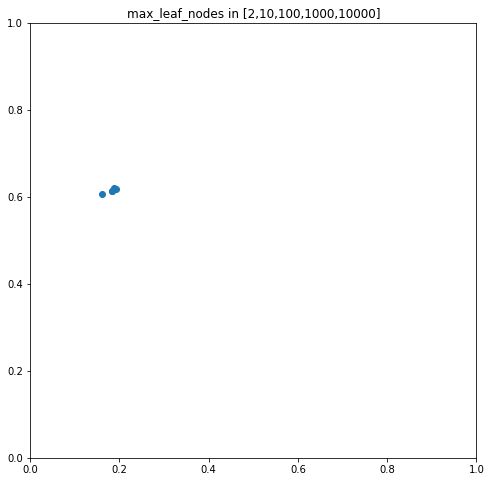

In [35]:
recall = [0.60750853242320824, 0.62116040955631402, 0.61433447098976113, 0.61433447098976113, 0.61774744027303752]
precision = [0.16196542311191992, 0.18821096173733196, 0.18404907975460122, 0.18461538461538463, 0.19173728813559321]

plt.figure(figsize=(8,8))
plt.scatter(precision, recall)
plt.axis([0, 1, 0,1])
plt.title('max_leaf_nodes in [2,10,100,1000,10000]')
plt.show()

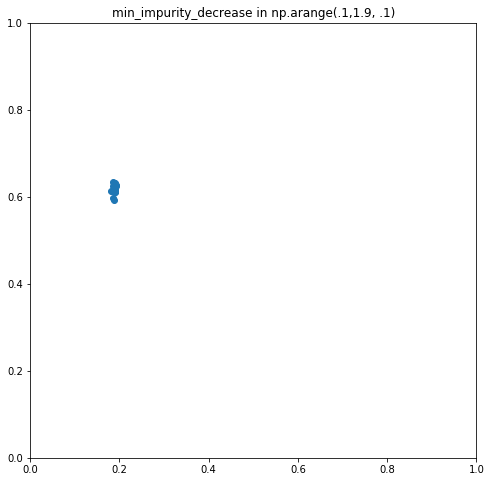

In [44]:
recall = [0.62457337883959041, 0.61092150170648463, 0.6348122866894198, 0.61092150170648463, 0.6313993174061433, 0.62798634812286691, 0.6313993174061433, 0.62116040955631402, 0.61433447098976113, 0.62116040955631402, 0.59385665529010234, 0.61774744027303752, 0.61433447098976113, 0.59726962457337884, 0.62457337883959041, 0.61774744027303752, 0.62457337883959041, 0.61433447098976113]
precision = [0.1880781089414183, 0.19002123142250532, 0.1852589641434263, 0.19103521878335111, 0.19072164948453607, 0.19186652763295098, 0.18705763397371081, 0.18938605619146723, 0.19088016967126192, 0.18938605619146723, 0.18770226537216828, 0.1893305439330544, 0.18442622950819673, 0.18636847710330137, 0.18635437881873726, 0.19092827004219409, 0.19202518363064008, 0.18090452261306533]
plt.figure(figsize=(8,8))
plt.scatter(precision, recall)
plt.axis([0, 1, 0,1])
plt.title('min_impurity_decrease in np.arange(.1,1.9, .1)')
plt.show()


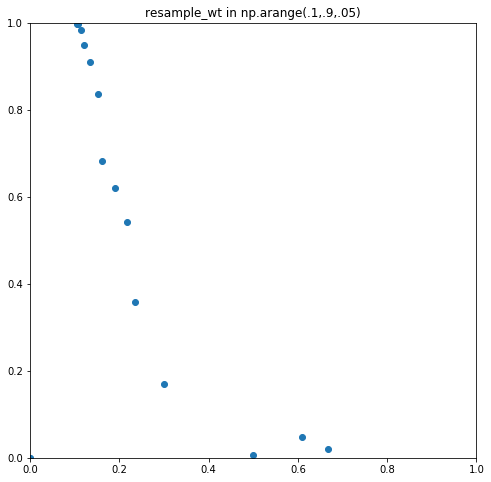

In [45]:

recall = [0.0, 0.0, 0.0068259385665529011, 0.020477815699658702, 0.04778156996587031, 0.17064846416382254, 0.35836177474402731, 0.5426621160409556, 0.62116040955631402, 0.68259385665529015, 0.83617747440273038, 0.9112627986348123, 0.94880546075085326, 0.98293515358361772, 0.9965870307167235, 0.9965870307167235]
precision = [0.0, 0.0, 0.5, 0.66666666666666663, 0.60869565217391308, 0.29940119760479039, 0.23542600896860988, 0.21662125340599456, 0.19017763845350052, 0.16181229773462782, 0.15245799626633477, 0.13430583501006035, 0.12118570183086312, 0.11378901619913077, 0.10814814814814815, 0.10522522522522522]
plt.figure(figsize=(8,8))
plt.scatter(precision, recall)
plt.axis([0, 1, 0,1])
plt.title('resample_wt in np.arange(.1,.9,.05)')
plt.show()

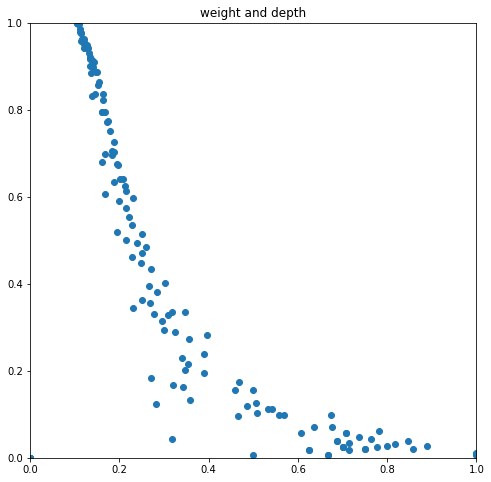

In [46]:
recall = [0.0, 0.0, 0.0, 0.017064846416382253, 0.037542662116040959, 0.12286689419795221, 0.34470989761092152, 0.51877133105802042, 0.60750853242320824, 0.67918088737201365, 0.83276450511945388, 0.94197952218430037, 0.97610921501706482, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0068259385665529011, 0.017064846416382253, 0.044368600682593858, 0.18430034129692832, 0.39590443686006827, 0.50170648464163825, 0.6348122866894198, 0.69965870307167233, 0.83617747440273038, 0.90102389078498291, 0.95221843003412965, 0.97610921501706482, 0.9965870307167235, 1.0, 0.0, 0.0068259385665529011, 0.017064846416382253, 0.034129692832764506, 0.11262798634812286, 0.22866894197952217, 0.33105802047781568, 0.46075085324232085, 0.59044368600682595, 0.69624573378839594, 0.79522184300341292, 0.89761092150170652, 0.94197952218430037, 0.96245733788395904, 0.97952218430034133, 0.9965870307167235, 0.0068259385665529011, 0.023890784982935155, 0.037542662116040959, 0.058020477815699661, 0.10238907849829351, 0.20136518771331058, 0.31399317406143346, 0.44709897610921501, 0.55290102389078499, 0.67235494880546076, 0.77133105802047786, 0.85665529010238906, 0.91467576791808869, 0.94539249146757676, 0.96245733788395904, 0.98634812286689422, 0.0068259385665529011, 0.023890784982935155, 0.023890784982935155, 0.058020477815699661, 0.09556313993174062, 0.16723549488054607, 0.29351535836177473, 0.36177474402730375, 0.4948805460750853, 0.62457337883959041, 0.70307167235494883, 0.79522184300341292, 0.88737201365187712, 0.91808873720136519, 0.94197952218430037, 0.95904436860068254, 0.010238907849829351, 0.023890784982935155, 0.04778156996587031, 0.058020477815699661, 0.12627986348122866, 0.17406143344709898, 0.27303754266211605, 0.33447098976109213, 0.43344709897610922, 0.53583617747440271, 0.64163822525597269, 0.726962457337884, 0.8225255972696246, 0.88737201365187712, 0.93174061433447097, 0.95563139931740615, 0.020477815699658702, 0.020477815699658702, 0.037542662116040959, 0.071672354948805458, 0.11262798634812286, 0.13310580204778158, 0.21501706484641639, 0.29010238907849828, 0.38225255972696248, 0.48464163822525597, 0.57337883959044367, 0.64163822525597269, 0.75085324232081907, 0.83617747440273038, 0.9112627986348123, 0.94880546075085326, 0.020477815699658702, 0.027303754266211604, 0.044368600682593858, 0.098976109215017066, 0.098976109215017066, 0.15699658703071673, 0.16382252559726962, 0.23890784982935154, 0.33447098976109213, 0.35494880546075086, 0.47098976109215018, 0.59726962457337884, 0.67576791808873715, 0.77474402730375425, 0.86348122866894195, 0.92150170648464169, 0.030716723549488054, 0.027303754266211604, 0.061433447098976107, 0.071672354948805458, 0.098976109215017066, 0.11945392491467577, 0.15699658703071673, 0.19453924914675769, 0.28327645051194539, 0.32764505119453924, 0.40273037542662116, 0.51535836177474403, 0.61433447098976113, 0.70648464163822522, 0.79522184300341292, 0.88395904436860073]
precision = [0.0, 0.0, 0.0, 0.625, 0.6875, 0.28125, 0.23165137614678899, 0.19562419562419561, 0.16792452830188678, 0.16022544283413848, 0.13871517907902217, 0.12147887323943662, 0.11353711790393013, 0.10685630926331145, 0.10539568345323741, 0.10531991373112869, 0.0, 0.0, 0.5, 0.625, 0.31707317073170732, 0.271356783919598, 0.26666666666666666, 0.2155425219941349, 0.18844984802431611, 0.16803278688524589, 0.1465311004784689, 0.13455657492354739, 0.1203104786545925, 0.11367249602543721, 0.10871183916604617, 0.10566173818968626, 0.0, 0.66666666666666663, 0.7142857142857143, 0.7142857142857143, 0.532258064516129, 0.34010152284263961, 0.27714285714285714, 0.2288135593220339, 0.20000000000000001, 0.18328840970350405, 0.160578911095796, 0.14094319399785638, 0.13018867924528302, 0.12025586353944563, 0.11259317379364457, 0.10838901262063845, 0.66666666666666663, 0.69999999999999996, 0.84615384615384615, 0.70833333333333337, 0.50847457627118642, 0.34705882352941175, 0.29581993569131831, 0.24810606060606061, 0.22252747252747251, 0.19719719719719719, 0.17265087853323147, 0.15111378687537627, 0.1392931392931393, 0.12665752171925013, 0.11628865979381443, 0.11085538933640199, 1.0, 0.77777777777777779, 0.69999999999999996, 0.6071428571428571, 0.46666666666666667, 0.3202614379084967, 0.29965156794425085, 0.25118483412322273, 0.24046434494195687, 0.21229698375870071, 0.18744313011828936, 0.1681096681096681, 0.14976958525345621, 0.13349875930521091, 0.12304948729380294, 0.11381125961927906, 1.0, 0.69999999999999996, 0.73684210526315785, 0.70833333333333337, 0.50684931506849318, 0.46788990825688076, 0.35555555555555557, 0.31818181818181818, 0.27078891257995735, 0.22886297376093295, 0.20796460176991149, 0.18866253321523471, 0.16316858496953285, 0.14789533560864618, 0.1319478008699855, 0.12001714530647235, 0.75, 0.8571428571428571, 0.6875, 0.67741935483870963, 0.54098360655737709, 0.3577981651376147, 0.3539325842696629, 0.32442748091603052, 0.28354430379746837, 0.25865209471766848, 0.2153846153846154, 0.20171673819742489, 0.17973856209150327, 0.16300731869594146, 0.14293361884368308, 0.12840646651270207, 0.75, 0.88888888888888884, 0.76470588235294112, 0.67441860465116277, 0.56862745098039214, 0.5, 0.34285714285714286, 0.3888888888888889, 0.3475177304964539, 0.26804123711340205, 0.25, 0.23117569352708059, 0.19545903257650543, 0.1735474006116208, 0.1547400611620795, 0.13392857142857142, 0.81818181818181823, 0.80000000000000004, 0.78260869565217395, 0.63636363636363635, 0.55769230769230771, 0.4861111111111111, 0.46000000000000002, 0.3904109589041096, 0.39523809523809522, 0.3086816720257235, 0.30179028132992325, 0.25166666666666665, 0.21582733812949639, 0.18416370106761565, 0.16091160220994474, 0.13747346072186836]
plt.figure(figsize=(8,8))
plt.scatter(precision, recall)
plt.axis([0, 1, 0,1])
plt.title('weight and depth')
plt.show()

In [47]:
resample_wt: 0.1, max_depth: 1, f1: nan,   rcll: 0.0,   prcsn: 0.0
resample_wt: 0.15000000000000002, max_depth: 1, f1: nan,   rcll: 0.0,   prcsn: 0.0
resample_wt: 0.20000000000000004, max_depth: 1, f1: nan,   rcll: 0.0,   prcsn: 0.0
resample_wt: 0.25000000000000006, max_depth: 1, f1: 0.0166,   rcll: 0.0171,   prcsn: 0.625
resample_wt: 0.30000000000000004, max_depth: 1, f1: 0.0356,   rcll: 0.0375,   prcsn: 0.688
resample_wt: 0.3500000000000001, max_depth: 1, f1: 0.0855,   rcll: 0.123,   prcsn: 0.281
resample_wt: 0.40000000000000013, max_depth: 1, f1: 0.139,   rcll: 0.345,   prcsn: 0.232
resample_wt: 0.45000000000000007, max_depth: 1, f1: 0.142,   rcll: 0.519,   prcsn: 0.196
resample_wt: 0.5000000000000001, max_depth: 1, f1: 0.132,   rcll: 0.608,   prcsn: 0.168
resample_wt: 0.5500000000000002, max_depth: 1, f1: 0.13,   rcll: 0.679,   prcsn: 0.16
resample_wt: 0.6000000000000002, max_depth: 1, f1: 0.119,   rcll: 0.833,   prcsn: 0.139
resample_wt: 0.6500000000000001, max_depth: 1, f1: 0.108,   rcll: 0.942,   prcsn: 0.121
resample_wt: 0.7000000000000002, max_depth: 1, f1: 0.102,   rcll: 0.976,   prcsn: 0.114
resample_wt: 0.7500000000000002, max_depth: 1, f1: 0.0965,   rcll: 1.0,   prcsn: 0.107
resample_wt: 0.8000000000000002, max_depth: 1, f1: 0.0953,   rcll: 1.0,   prcsn: 0.105
resample_wt: 0.8500000000000002, max_depth: 1, f1: 0.0953,   rcll: 1.0,   prcsn: 0.105
resample_wt: 0.1, max_depth: 2, f1: nan,   rcll: 0.0,   prcsn: 0.0
resample_wt: 0.15000000000000002, max_depth: 2, f1: nan,   rcll: 0.0,   prcsn: 0.0
resample_wt: 0.20000000000000004, max_depth: 2, f1: 0.00673,   rcll: 0.00683,   prcsn: 0.5
resample_wt: 0.25000000000000006, max_depth: 2, f1: 0.0166,   rcll: 0.0171,   prcsn: 0.625
resample_wt: 0.30000000000000004, max_depth: 2, f1: 0.0389,   rcll: 0.0444,   prcsn: 0.317
resample_wt: 0.3500000000000001, max_depth: 2, f1: 0.11,   rcll: 0.184,   prcsn: 0.271
resample_wt: 0.40000000000000013, max_depth: 2, f1: 0.159,   rcll: 0.396,   prcsn: 0.267
resample_wt: 0.45000000000000007, max_depth: 2, f1: 0.151,   rcll: 0.502,   prcsn: 0.216
resample_wt: 0.5000000000000001, max_depth: 2, f1: 0.145,   rcll: 0.635,   prcsn: 0.188
resample_wt: 0.5500000000000002, max_depth: 2, f1: 0.135,   rcll: 0.7,   prcsn: 0.168
resample_wt: 0.6000000000000002, max_depth: 2, f1: 0.125,   rcll: 0.836,   prcsn: 0.147
resample_wt: 0.6500000000000001, max_depth: 2, f1: 0.117,   rcll: 0.901,   prcsn: 0.135
resample_wt: 0.7000000000000002, max_depth: 2, f1: 0.107,   rcll: 0.952,   prcsn: 0.12
resample_wt: 0.7500000000000002, max_depth: 2, f1: 0.102,   rcll: 0.976,   prcsn: 0.114
resample_wt: 0.8000000000000002, max_depth: 2, f1: 0.098,   rcll: 0.997,   prcsn: 0.109
resample_wt: 0.8500000000000002, max_depth: 2, f1: 0.0956,   rcll: 1.0,   prcsn: 0.106
resample_wt: 0.1, max_depth: 3, f1: nan,   rcll: 0.0,   prcsn: 0.0
resample_wt: 0.15000000000000002, max_depth: 3, f1: 0.00676,   rcll: 0.00683,   prcsn: 0.667
resample_wt: 0.20000000000000004, max_depth: 3, f1: 0.0167,   rcll: 0.0171,   prcsn: 0.714
resample_wt: 0.25000000000000006, max_depth: 3, f1: 0.0326,   rcll: 0.0341,   prcsn: 0.714
resample_wt: 0.30000000000000004, max_depth: 3, f1: 0.093,   rcll: 0.113,   prcsn: 0.532
resample_wt: 0.3500000000000001, max_depth: 3, f1: 0.137,   rcll: 0.229,   prcsn: 0.34
resample_wt: 0.40000000000000013, max_depth: 3, f1: 0.151,   rcll: 0.331,   prcsn: 0.277
resample_wt: 0.45000000000000007, max_depth: 3, f1: 0.153,   rcll: 0.461,   prcsn: 0.229
resample_wt: 0.5000000000000001, max_depth: 3, f1: 0.149,   rcll: 0.59,   prcsn: 0.2
resample_wt: 0.5500000000000002, max_depth: 3, f1: 0.145,   rcll: 0.696,   prcsn: 0.183
resample_wt: 0.6000000000000002, max_depth: 3, f1: 0.134,   rcll: 0.795,   prcsn: 0.161
resample_wt: 0.6500000000000001, max_depth: 3, f1: 0.122,   rcll: 0.898,   prcsn: 0.141
resample_wt: 0.7000000000000002, max_depth: 3, f1: 0.114,   rcll: 0.942,   prcsn: 0.13
resample_wt: 0.7500000000000002, max_depth: 3, f1: 0.107,   rcll: 0.962,   prcsn: 0.12
resample_wt: 0.8000000000000002, max_depth: 3, f1: 0.101,   rcll: 0.98,   prcsn: 0.113
resample_wt: 0.8500000000000002, max_depth: 3, f1: 0.0978,   rcll: 0.997,   prcsn: 0.108
resample_wt: 0.1, max_depth: 4, f1: 0.00676,   rcll: 0.00683,   prcsn: 0.667
resample_wt: 0.15000000000000002, max_depth: 4, f1: 0.0231,   rcll: 0.0239,   prcsn: 0.7
resample_wt: 0.20000000000000004, max_depth: 4, f1: 0.0359,   rcll: 0.0375,   prcsn: 0.846
resample_wt: 0.25000000000000006, max_depth: 4, f1: 0.0536,   rcll: 0.058,   prcsn: 0.708
resample_wt: 0.30000000000000004, max_depth: 4, f1: 0.0852,   rcll: 0.102,   prcsn: 0.508
resample_wt: 0.3500000000000001, max_depth: 4, f1: 0.127,   rcll: 0.201,   prcsn: 0.347
resample_wt: 0.40000000000000013, max_depth: 4, f1: 0.152,   rcll: 0.314,   prcsn: 0.296
resample_wt: 0.45000000000000007, max_depth: 4, f1: 0.16,   rcll: 0.447,   prcsn: 0.248
resample_wt: 0.5000000000000001, max_depth: 4, f1: 0.159,   rcll: 0.553,   prcsn: 0.223
resample_wt: 0.5500000000000002, max_depth: 4, f1: 0.152,   rcll: 0.672,   prcsn: 0.197
resample_wt: 0.6000000000000002, max_depth: 4, f1: 0.141,   rcll: 0.771,   prcsn: 0.173
resample_wt: 0.6500000000000001, max_depth: 4, f1: 0.128,   rcll: 0.857,   prcsn: 0.151
resample_wt: 0.7000000000000002, max_depth: 4, f1: 0.121,   rcll: 0.915,   prcsn: 0.139
resample_wt: 0.7500000000000002, max_depth: 4, f1: 0.112,   rcll: 0.945,   prcsn: 0.127
resample_wt: 0.8000000000000002, max_depth: 4, f1: 0.104,   rcll: 0.962,   prcsn: 0.116
resample_wt: 0.8500000000000002, max_depth: 4, f1: 0.0997,   rcll: 0.986,   prcsn: 0.111
resample_wt: 0.1, max_depth: 5, f1: 0.00678,   rcll: 0.00683,   prcsn: 1.0
resample_wt: 0.15000000000000002, max_depth: 5, f1: 0.0232,   rcll: 0.0239,   prcsn: 0.778
resample_wt: 0.20000000000000004, max_depth: 5, f1: 0.0231,   rcll: 0.0239,   prcsn: 0.7
resample_wt: 0.25000000000000006, max_depth: 5, f1: 0.053,   rcll: 0.058,   prcsn: 0.607
resample_wt: 0.30000000000000004, max_depth: 5, f1: 0.0793,   rcll: 0.0956,   prcsn: 0.467
resample_wt: 0.3500000000000001, max_depth: 5, f1: 0.11,   rcll: 0.167,   prcsn: 0.32
resample_wt: 0.40000000000000013, max_depth: 5, f1: 0.148,   rcll: 0.294,   prcsn: 0.3
resample_wt: 0.45000000000000007, max_depth: 5, f1: 0.148,   rcll: 0.362,   prcsn: 0.251
resample_wt: 0.5000000000000001, max_depth: 5, f1: 0.162,   rcll: 0.495,   prcsn: 0.24
resample_wt: 0.5500000000000002, max_depth: 5, f1: 0.158,   rcll: 0.625,   prcsn: 0.212
resample_wt: 0.6000000000000002, max_depth: 5, f1: 0.148,   rcll: 0.703,   prcsn: 0.187
resample_wt: 0.6500000000000001, max_depth: 5, f1: 0.139,   rcll: 0.795,   prcsn: 0.168
resample_wt: 0.7000000000000002, max_depth: 5, f1: 0.128,   rcll: 0.887,   prcsn: 0.15
resample_wt: 0.7500000000000002, max_depth: 5, f1: 0.117,   rcll: 0.918,   prcsn: 0.133
resample_wt: 0.8000000000000002, max_depth: 5, f1: 0.109,   rcll: 0.942,   prcsn: 0.123
resample_wt: 0.8500000000000002, max_depth: 5, f1: 0.102,   rcll: 0.959,   prcsn: 0.114
resample_wt: 0.1, max_depth: 6, f1: 0.0101,   rcll: 0.0102,   prcsn: 1.0
resample_wt: 0.15000000000000002, max_depth: 6, f1: 0.0231,   rcll: 0.0239,   prcsn: 0.7
resample_wt: 0.20000000000000004, max_depth: 6, f1: 0.0449,   rcll: 0.0478,   prcsn: 0.737
resample_wt: 0.25000000000000006, max_depth: 6, f1: 0.0536,   rcll: 0.058,   prcsn: 0.708
resample_wt: 0.30000000000000004, max_depth: 6, f1: 0.101,   rcll: 0.126,   prcsn: 0.507
resample_wt: 0.3500000000000001, max_depth: 6, f1: 0.127,   rcll: 0.174,   prcsn: 0.468
resample_wt: 0.40000000000000013, max_depth: 6, f1: 0.154,   rcll: 0.273,   prcsn: 0.356
resample_wt: 0.45000000000000007, max_depth: 6, f1: 0.163,   rcll: 0.334,   prcsn: 0.318
resample_wt: 0.5000000000000001, max_depth: 6, f1: 0.167,   rcll: 0.433,   prcsn: 0.271
resample_wt: 0.5500000000000002, max_depth: 6, f1: 0.16,   rcll: 0.536,   prcsn: 0.229
resample_wt: 0.6000000000000002, max_depth: 6, f1: 0.157,   rcll: 0.642,   prcsn: 0.208
resample_wt: 0.6500000000000001, max_depth: 6, f1: 0.15,   rcll: 0.727,   prcsn: 0.189
resample_wt: 0.7000000000000002, max_depth: 6, f1: 0.136,   rcll: 0.823,   prcsn: 0.163
resample_wt: 0.7500000000000002, max_depth: 6, f1: 0.127,   rcll: 0.887,   prcsn: 0.148
resample_wt: 0.8000000000000002, max_depth: 6, f1: 0.116,   rcll: 0.932,   prcsn: 0.132
resample_wt: 0.8500000000000002, max_depth: 6, f1: 0.107,   rcll: 0.956,   prcsn: 0.12
resample_wt: 0.1, max_depth: 7, f1: 0.0199,   rcll: 0.0205,   prcsn: 0.75
resample_wt: 0.15000000000000002, max_depth: 7, f1: 0.02,   rcll: 0.0205,   prcsn: 0.857
resample_wt: 0.20000000000000004, max_depth: 7, f1: 0.0356,   rcll: 0.0375,   prcsn: 0.688
resample_wt: 0.25000000000000006, max_depth: 7, f1: 0.0648,   rcll: 0.0717,   prcsn: 0.677
resample_wt: 0.30000000000000004, max_depth: 7, f1: 0.0932,   rcll: 0.113,   prcsn: 0.541
resample_wt: 0.3500000000000001, max_depth: 7, f1: 0.097,   rcll: 0.133,   prcsn: 0.358
resample_wt: 0.40000000000000013, max_depth: 7, f1: 0.134,   rcll: 0.215,   prcsn: 0.354
resample_wt: 0.45000000000000007, max_depth: 7, f1: 0.153,   rcll: 0.29,   prcsn: 0.324
resample_wt: 0.5000000000000001, max_depth: 7, f1: 0.163,   rcll: 0.382,   prcsn: 0.284
resample_wt: 0.5500000000000002, max_depth: 7, f1: 0.169,   rcll: 0.485,   prcsn: 0.259
resample_wt: 0.6000000000000002, max_depth: 7, f1: 0.157,   rcll: 0.573,   prcsn: 0.215
resample_wt: 0.6500000000000001, max_depth: 7, f1: 0.153,   rcll: 0.642,   prcsn: 0.202
resample_wt: 0.7000000000000002, max_depth: 7, f1: 0.145,   rcll: 0.751,   prcsn: 0.18
resample_wt: 0.7500000000000002, max_depth: 7, f1: 0.136,   rcll: 0.836,   prcsn: 0.163
resample_wt: 0.8000000000000002, max_depth: 7, f1: 0.124,   rcll: 0.911,   prcsn: 0.143
resample_wt: 0.8500000000000002, max_depth: 7, f1: 0.113,   rcll: 0.949,   prcsn: 0.128
resample_wt: 0.1, max_depth: 8, f1: 0.0199,   rcll: 0.0205,   prcsn: 0.75
resample_wt: 0.15000000000000002, max_depth: 8, f1: 0.0265,   rcll: 0.0273,   prcsn: 0.889
resample_wt: 0.20000000000000004, max_depth: 8, f1: 0.0419,   rcll: 0.0444,   prcsn: 0.765
resample_wt: 0.25000000000000006, max_depth: 8, f1: 0.0863,   rcll: 0.099,   prcsn: 0.674
resample_wt: 0.30000000000000004, max_depth: 8, f1: 0.0843,   rcll: 0.099,   prcsn: 0.569
resample_wt: 0.3500000000000001, max_depth: 8, f1: 0.119,   rcll: 0.157,   prcsn: 0.5
resample_wt: 0.40000000000000013, max_depth: 8, f1: 0.111,   rcll: 0.164,   prcsn: 0.343
resample_wt: 0.45000000000000007, max_depth: 8, f1: 0.148,   rcll: 0.239,   prcsn: 0.389
resample_wt: 0.5000000000000001, max_depth: 8, f1: 0.17,   rcll: 0.334,   prcsn: 0.348
resample_wt: 0.5500000000000002, max_depth: 8, f1: 0.153,   rcll: 0.355,   prcsn: 0.268
resample_wt: 0.6000000000000002, max_depth: 8, f1: 0.163,   rcll: 0.471,   prcsn: 0.25
resample_wt: 0.6500000000000001, max_depth: 8, f1: 0.167,   rcll: 0.597,   prcsn: 0.231
resample_wt: 0.7000000000000002, max_depth: 8, f1: 0.152,   rcll: 0.676,   prcsn: 0.195
resample_wt: 0.7500000000000002, max_depth: 8, f1: 0.142,   rcll: 0.775,   prcsn: 0.174
resample_wt: 0.8000000000000002, max_depth: 8, f1: 0.131,   rcll: 0.863,   prcsn: 0.155
resample_wt: 0.8500000000000002, max_depth: 8, f1: 0.117,   rcll: 0.922,   prcsn: 0.134
resample_wt: 0.1, max_depth: 9, f1: 0.0296,   rcll: 0.0307,   prcsn: 0.818
resample_wt: 0.15000000000000002, max_depth: 9, f1: 0.0264,   rcll: 0.0273,   prcsn: 0.8
resample_wt: 0.20000000000000004, max_depth: 9, f1: 0.057,   rcll: 0.0614,   prcsn: 0.783
resample_wt: 0.25000000000000006, max_depth: 9, f1: 0.0644,   rcll: 0.0717,   prcsn: 0.636
resample_wt: 0.30000000000000004, max_depth: 9, f1: 0.0841,   rcll: 0.099,   prcsn: 0.558
resample_wt: 0.3500000000000001, max_depth: 9, f1: 0.0959,   rcll: 0.119,   prcsn: 0.486
resample_wt: 0.40000000000000013, max_depth: 9, f1: 0.117,   rcll: 0.157,   prcsn: 0.46
resample_wt: 0.45000000000000007, max_depth: 9, f1: 0.13,   rcll: 0.195,   prcsn: 0.39
resample_wt: 0.5000000000000001, max_depth: 9, f1: 0.165,   rcll: 0.283,   prcsn: 0.395
resample_wt: 0.5500000000000002, max_depth: 9, f1: 0.159,   rcll: 0.328,   prcsn: 0.309
resample_wt: 0.6000000000000002, max_depth: 9, f1: 0.173,   rcll: 0.403,   prcsn: 0.302
resample_wt: 0.6500000000000001, max_depth: 9, f1: 0.169,   rcll: 0.515,   prcsn: 0.252
resample_wt: 0.7000000000000002, max_depth: 9, f1: 0.16,   rcll: 0.614,   prcsn: 0.216
resample_wt: 0.7500000000000002, max_depth: 9, f1: 0.146,   rcll: 0.706,   prcsn: 0.184
resample_wt: 0.8000000000000002, max_depth: 9, f1: 0.134,   rcll: 0.795,   prcsn: 0.161
resample_wt: 0.8500000000000002, max_depth: 9, f1: 0.119,   rcll: 0.884,   prcsn: 0.137

SyntaxError: invalid syntax (<ipython-input-47-0bdd55be9d4a>, line 1)

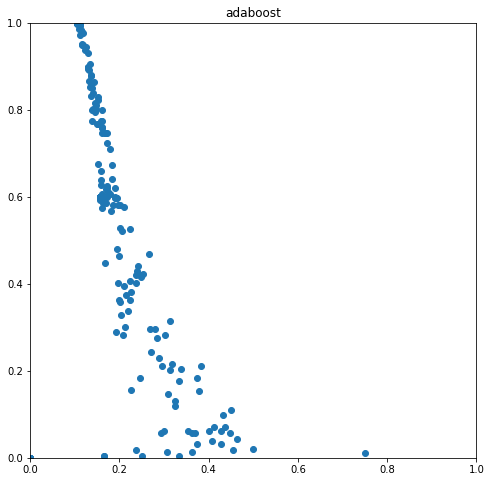

In [48]:
recall = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.013651877133105802, 0.0, 0.0, 0.0, 0.0034129692832764505, 0.017064846416382253, 0.0, 0.0, 0.0034129692832764505, 0.030716723549488054, 0.071672354948805458, 0.0, 0.0034129692832764505, 0.013651877133105802, 0.058020477815699661, 0.098976109215017066, 0.0, 0.0, 0.0, 0.0, 0.071672354948805458, 0.0, 0.0, 0.0, 0.0, 0.058020477815699661, 0.0, 0.0, 0.0, 0.044368600682593858, 0.11945392491467577, 0.0, 0.0, 0.010238907849829351, 0.058020477815699661, 0.12969283276450511, 0.0, 0.017064846416382253, 0.061433447098976107, 0.15358361774744028, 0.17747440273037543, 0.0034129692832764505, 0.061433447098976107, 0.10921501706484642, 0.18430034129692832, 0.21160409556313994, 0.0, 0.0, 0.0, 0.0, 0.15699658703071673, 0.0, 0.0, 0.0, 0.061433447098976107, 0.18430034129692832, 0.0, 0.0, 0.020477815699658702, 0.20136518771331058, 0.24232081911262798, 0.0, 0.030716723549488054, 0.061433447098976107, 0.21160409556313994, 0.29692832764505117, 0.037542662116040959, 0.14675767918088736, 0.21501706484641639, 0.2764505119453925, 0.29692832764505117, 0.058020477815699661, 0.20477815699658702, 0.22866894197952217, 0.28327645051194539, 0.31399317406143346, 0.58703071672354945, 0.59044368600682595, 0.60068259385665534, 0.29010238907849828, 0.46416382252559729, 0.60068259385665534, 0.59044368600682595, 0.48122866894197952, 0.36177474402730375, 0.35836177474402731, 0.57337883959044367, 0.40273037542662116, 0.30034129692832767, 0.37542662116040953, 0.39590443686006827, 0.44709897610921501, 0.32764505119453924, 0.36177474402730375, 0.4061433447098976, 0.44027303754266212, 0.28327645051194539, 0.38225255972696248, 0.41979522184300339, 0.42320819112627989, 0.46757679180887374, 0.33788395904436858, 0.40273037542662116, 0.43003412969283278, 0.41979522184300339, 0.41638225255972694, 0.60068259385665534, 0.59044368600682595, 0.60068259385665534, 0.62798634812286691, 0.61092150170648463, 0.60068259385665534, 0.60068259385665534, 0.60068259385665534, 0.60068259385665534, 0.58703071672354945, 0.60068259385665534, 0.60750853242320824, 0.62457337883959041, 0.56655290102389078, 0.59726962457337884, 0.59385665529010234, 0.61774744027303752, 0.60750853242320824, 0.58020477815699656, 0.58020477815699656, 0.62116040955631402, 0.60068259385665534, 0.59726962457337884, 0.57679180887372017, 0.52218430034129693, 0.60750853242320824, 0.59726962457337884, 0.58020477815699656, 0.52901023890784982, 0.52559726962457343, 0.60068259385665534, 0.60068259385665534, 0.60068259385665534, 0.79863481228668942, 0.67576791808873715, 0.60068259385665534, 0.60068259385665534, 0.65870307167235498, 0.80204778156996592, 0.76791808873720135, 0.60068259385665534, 0.85324232081911267, 0.77474402730375425, 0.77474402730375425, 0.74744027303754268, 0.63822525597269619, 0.83276450511945388, 0.8122866894197952, 0.74744027303754268, 0.7235494880546075, 0.79522184300341292, 0.76791808873720135, 0.76109215017064846, 0.70989761092150172, 0.64163822525597269, 0.80204778156996592, 0.75767918088737196, 0.74744027303754268, 0.67235494880546076, 0.62116040955631402, 1.0, 1.0, 1.0, 1.0, 0.89761092150170652, 1.0, 1.0, 1.0, 0.98293515358361772, 0.89078498293515362, 1.0, 1.0, 0.9965870307167235, 0.90443686006825941, 0.83959044368600677, 1.0, 0.9965870307167235, 0.97610921501706482, 0.86006825938566556, 0.82935153583617749, 1.0, 0.93174061433447097, 0.86689419795221845, 0.8225255972696246, 0.77474402730375425, 0.97952218430034133, 0.87713310580204773, 0.86348122866894195, 0.79863481228668942, 0.74744027303754268, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99317406143344711, 1.0, 1.0, 1.0, 0.97269624573378843, 0.94539249146757676, 1.0, 1.0, 1.0, 0.94880546075085326, 0.89761092150170652, 1.0, 0.98634812286689422, 0.94880546075085326, 0.89419795221843001, 0.84982935153583616, 0.9965870307167235, 0.95221843003412965, 0.93856655290102387, 0.88054607508532423, 0.81569965870307171]
precision = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.30769230769230771, 0.0, 0.0, 0.0, 0.25, 0.23809523809523808, 0.0, 0.0, 0.16666666666666666, 0.375, 0.4375, 0.0, 0.16666666666666666, 0.36363636363636365, 0.44736842105263158, 0.43283582089552236, 0.0, 0.0, 0.0, 0.0, 0.41176470588235292, 0.0, 0.0, 0.0, 0.0, 0.29310344827586204, 0.0, 0.0, 0.0, 0.4642857142857143, 0.32407407407407407, 0.0, 0.0, 0.75, 0.36170212765957449, 0.3247863247863248, 0.0, 0.45454545454545453, 0.42857142857142855, 0.37815126050420167, 0.33333333333333331, 0.33333333333333331, 0.35294117647058826, 0.45070422535211269, 0.375, 0.38271604938271603, 0.0, 0.0, 0.0, 0.0, 0.22660098522167488, 0.0, 0.0, 0.0, 0.40000000000000002, 0.24657534246575341, 0.0, 0.0, 0.5, 0.31382978723404253, 0.27099236641221375, 0.0, 0.42857142857142855, 0.29999999999999999, 0.29665071770334928, 0.26851851851851855, 0.40740740740740738, 0.30935251798561153, 0.31818181818181818, 0.28321678321678323, 0.27974276527331188, 0.36956521739130432, 0.33707865168539325, 0.28879310344827586, 0.3029197080291971, 0.31292517006802723, 0.16226415094339622, 0.16259398496240601, 0.15813117699910154, 0.19230769230769232, 0.19825072886297376, 0.15630550621669628, 0.16259398496240601, 0.19394773039889959, 0.19887429643527205, 0.20038167938931298, 0.16169393647738209, 0.19633943427620631, 0.21359223300970873, 0.2140077821011673, 0.20938628158844766, 0.16709183673469388, 0.20338983050847459, 0.22457627118644069, 0.22326454033771106, 0.2424812030075188, 0.20906801007556675, 0.22580645161290322, 0.23653846153846153, 0.2530612244897959, 0.26705653021442494, 0.21902654867256638, 0.23694779116465864, 0.23863636363636365, 0.24949290060851928, 0.24796747967479674, 0.15630550621669628, 0.16259398496240601, 0.15630550621669628, 0.15944540727902945, 0.17566241413150147, 0.15630550621669628, 0.15630550621669628, 0.15728328865058089, 0.17322834645669291, 0.17012858555885263, 0.15630550621669628, 0.16108597285067874, 0.17247879359095195, 0.18082788671023964, 0.19422863485016648, 0.15675675675675677, 0.16931711880261927, 0.17711442786069651, 0.18681318681318682, 0.19767441860465115, 0.17169811320754716, 0.18985976267529667, 0.19021739130434784, 0.21151439299123906, 0.20592193808882908, 0.17871485943775101, 0.19273127753303965, 0.20118343195266272, 0.20208604954367665, 0.22448979591836735, 0.15630550621669628, 0.15630550621669628, 0.15630550621669628, 0.13895486935866982, 0.15184049079754602, 0.15630550621669628, 0.15630550621669628, 0.15990057995028997, 0.14114114114114115, 0.14950166112956811, 0.15813117699910154, 0.13520822065981611, 0.13960639606396064, 0.15829846582984658, 0.16885119506553586, 0.15996578272027373, 0.13585746102449889, 0.14700432365657815, 0.16174298375184637, 0.17165991902834007, 0.14436183395291202, 0.15161725067385445, 0.16077865897620763, 0.17946505608283003, 0.18323586744639375, 0.14696685428392744, 0.16063675832127353, 0.16730328495034377, 0.18394024276377219, 0.1903765690376569, 0.10531991373112869, 0.10531991373112869, 0.10531991373112869, 0.10531991373112869, 0.12923832923832923, 0.10531991373112869, 0.10531991373112869, 0.10531991373112869, 0.11501597444089456, 0.13248730964467004, 0.10531991373112869, 0.10531991373112869, 0.1106899166034875, 0.13336688475088074, 0.14195037507212926, 0.10531991373112869, 0.11166347992351816, 0.11823067383216206, 0.13599568267674042, 0.15244667503136763, 0.11200305810397554, 0.12920018930430668, 0.13298429319371727, 0.1531130876747141, 0.16133617626154939, 0.11610032362459546, 0.13576333861595352, 0.14221472737492974, 0.16049382716049382, 0.17298578199052134, 0.10531991373112869, 0.10531991373112869, 0.10531991373112869, 0.10531991373112869, 0.10531991373112869, 0.10531991373112869, 0.10531991373112869, 0.10531991373112869, 0.10531991373112869, 0.11094166984369043, 0.10531991373112869, 0.10531991373112869, 0.10531991373112869, 0.11198428290766209, 0.1259663483401546, 0.10531991373112869, 0.10531991373112869, 0.10535778496943546, 0.11839863713798977, 0.12892156862745099, 0.10531991373112869, 0.11034746086292478, 0.11544850498338871, 0.1291276490882208, 0.13841022790439134, 0.10503597122302158, 0.11586378737541528, 0.12222222222222222, 0.13550420168067226, 0.14467312348668282]

plt.figure(figsize=(8,8))
plt.scatter(precision, recall)
plt.axis([0, 1, 0,1])
plt.title('adaboost')
plt.show()

In [ ]:
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
3_gridsearch.py:138: RuntimeWarning: invalid value encountered in double_scalars
  f1 = (recall*precision)/(recall + precision)
rsmp_wt: 0.1, n_est: 5, lrng_rate: 0.01, f1: nan,   rcll: 0.0,   prcsn: 0.0
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
3_gridsearch.py:138: RuntimeWarning: invalid value encountered in double_scalars
  f1 = (recall*precision)/(recall + precision)
rsmp_wt: 0.1, n_est: 5, lrng_rate: 0.05, f1: nan,   rcll: 0.0,   prcsn: 0.0
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
3_gridsearch.py:138: RuntimeWarning: invalid value encountered in double_scalars
  f1 = (recall*precision)/(recall + precision)
rsmp_wt: 0.1, n_est: 5, lrng_rate: 0.1, f1: nan,   rcll: 0.0,   prcsn: 0.0
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
3_gridsearch.py:138: RuntimeWarning: invalid value encountered in double_scalars
  f1 = (recall*precision)/(recall + precision)
rsmp_wt: 0.1, n_est: 5, lrng_rate: 0.5, f1: nan,   rcll: 0.0,   prcsn: 0.0
3_gridsearch.py:138: RuntimeWarning: invalid value encountered in double_scalars
  f1 = (recall*precision)/(recall + precision)
rsmp_wt: 0.1, n_est: 5, lrng_rate: 1, f1: nan,   rcll: 0.0,   prcsn: 0.0
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
3_gridsearch.py:138: RuntimeWarning: invalid value encountered in double_scalars
  f1 = (recall*precision)/(recall + precision)
rsmp_wt: 0.1, n_est: 10, lrng_rate: 0.01, f1: nan,   rcll: 0.0,   prcsn: 0.0
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
3_gridsearch.py:138: RuntimeWarning: invalid value encountered in double_scalars
  f1 = (recall*precision)/(recall + precision)
rsmp_wt: 0.1, n_est: 10, lrng_rate: 0.05, f1: nan,   rcll: 0.0,   prcsn: 0.0
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
3_gridsearch.py:138: RuntimeWarning: invalid value encountered in double_scalars
  f1 = (recall*precision)/(recall + precision)
rsmp_wt: 0.1, n_est: 10, lrng_rate: 0.1, f1: nan,   rcll: 0.0,   prcsn: 0.0
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
3_gridsearch.py:138: RuntimeWarning: invalid value encountered in double_scalars
  f1 = (recall*precision)/(recall + precision)
rsmp_wt: 0.1, n_est: 10, lrng_rate: 0.5, f1: nan,   rcll: 0.0,   prcsn: 0.0
3_gridsearch.py:138: RuntimeWarning: invalid value encountered in double_scalars
  f1 = (recall*precision)/(recall + precision)
rsmp_wt: 0.1, n_est: 10, lrng_rate: 1, f1: nan,   rcll: 0.0,   prcsn: 0.0
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
3_gridsearch.py:138: RuntimeWarning: invalid value encountered in double_scalars
  f1 = (recall*precision)/(recall + precision)
rsmp_wt: 0.1, n_est: 50, lrng_rate: 0.01, f1: nan,   rcll: 0.0,   prcsn: 0.0
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
3_gridsearch.py:138: RuntimeWarning: invalid value encountered in double_scalars
  f1 = (recall*precision)/(recall + precision)
rsmp_wt: 0.1, n_est: 50, lrng_rate: 0.05, f1: nan,   rcll: 0.0,   prcsn: 0.0
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
3_gridsearch.py:138: RuntimeWarning: invalid value encountered in double_scalars
  f1 = (recall*precision)/(recall + precision)
rsmp_wt: 0.1, n_est: 50, lrng_rate: 0.1, f1: nan,   rcll: 0.0,   prcsn: 0.0
3_gridsearch.py:138: RuntimeWarning: invalid value encountered in double_scalars
  f1 = (recall*precision)/(recall + precision)
rsmp_wt: 0.1, n_est: 50, lrng_rate: 0.5, f1: nan,   rcll: 0.0,   prcsn: 0.0
rsmp_wt: 0.1, n_est: 50, lrng_rate: 1, f1: 0.0131,   rcll: 0.0137,   prcsn: 0.308
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
3_gridsearch.py:138: RuntimeWarning: invalid value encountered in double_scalars
  f1 = (recall*precision)/(recall + precision)
rsmp_wt: 0.1, n_est: 100, lrng_rate: 0.01, f1: nan,   rcll: 0.0,   prcsn: 0.0
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
3_gridsearch.py:138: RuntimeWarning: invalid value encountered in double_scalars
  f1 = (recall*precision)/(recall + precision)
rsmp_wt: 0.1, n_est: 100, lrng_rate: 0.05, f1: nan,   rcll: 0.0,   prcsn: 0.0
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
3_gridsearch.py:138: RuntimeWarning: invalid value encountered in double_scalars
  f1 = (recall*precision)/(recall + precision)
rsmp_wt: 0.1, n_est: 100, lrng_rate: 0.1, f1: nan,   rcll: 0.0,   prcsn: 0.0
rsmp_wt: 0.1, n_est: 100, lrng_rate: 0.5, f1: 0.00337,   rcll: 0.00341,   prcsn: 0.25
rsmp_wt: 0.1, n_est: 100, lrng_rate: 1, f1: 0.0159,   rcll: 0.0171,   prcsn: 0.238
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
3_gridsearch.py:138: RuntimeWarning: invalid value encountered in double_scalars
  f1 = (recall*precision)/(recall + precision)
rsmp_wt: 0.1, n_est: 500, lrng_rate: 0.01, f1: nan,   rcll: 0.0,   prcsn: 0.0
3_gridsearch.py:138: RuntimeWarning: invalid value encountered in double_scalars
  f1 = (recall*precision)/(recall + precision)
rsmp_wt: 0.1, n_est: 500, lrng_rate: 0.05, f1: nan,   rcll: 0.0,   prcsn: 0.0
rsmp_wt: 0.1, n_est: 500, lrng_rate: 0.1, f1: 0.00334,   rcll: 0.00341,   prcsn: 0.167
rsmp_wt: 0.1, n_est: 500, lrng_rate: 0.5, f1: 0.0284,   rcll: 0.0307,   prcsn: 0.375
rsmp_wt: 0.1, n_est: 500, lrng_rate: 1, f1: 0.0616,   rcll: 0.0717,   prcsn: 0.438
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
3_gridsearch.py:138: RuntimeWarning: invalid value encountered in double_scalars
  f1 = (recall*precision)/(recall + precision)
rsmp_wt: 0.1, n_est: 1000, lrng_rate: 0.01, f1: nan,   rcll: 0.0,   prcsn: 0.0
rsmp_wt: 0.1, n_est: 1000, lrng_rate: 0.05, f1: 0.00334,   rcll: 0.00341,   prcsn: 0.167
rsmp_wt: 0.1, n_est: 1000, lrng_rate: 0.1, f1: 0.0132,   rcll: 0.0137,   prcsn: 0.364
rsmp_wt: 0.1, n_est: 1000, lrng_rate: 0.5, f1: 0.0514,   rcll: 0.058,   prcsn: 0.447
rsmp_wt: 0.1, n_est: 1000, lrng_rate: 1, f1: 0.0806,   rcll: 0.099,   prcsn: 0.433
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
3_gridsearch.py:138: RuntimeWarning: invalid value encountered in double_scalars
  f1 = (recall*precision)/(recall + precision)
rsmp_wt: 0.2, n_est: 5, lrng_rate: 0.01, f1: nan,   rcll: 0.0,   prcsn: 0.0
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
3_gridsearch.py:138: RuntimeWarning: invalid value encountered in double_scalars
  f1 = (recall*precision)/(recall + precision)
rsmp_wt: 0.2, n_est: 5, lrng_rate: 0.05, f1: nan,   rcll: 0.0,   prcsn: 0.0
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
3_gridsearch.py:138: RuntimeWarning: invalid value encountered in double_scalars
  f1 = (recall*precision)/(recall + precision)
rsmp_wt: 0.2, n_est: 5, lrng_rate: 0.1, f1: nan,   rcll: 0.0,   prcsn: 0.0
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
3_gridsearch.py:138: RuntimeWarning: invalid value encountered in double_scalars
  f1 = (recall*precision)/(recall + precision)
rsmp_wt: 0.2, n_est: 5, lrng_rate: 0.5, f1: nan,   rcll: 0.0,   prcsn: 0.0
rsmp_wt: 0.2, n_est: 5, lrng_rate: 1, f1: 0.061,   rcll: 0.0717,   prcsn: 0.412
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
3_gridsearch.py:138: RuntimeWarning: invalid value encountered in double_scalars
  f1 = (recall*precision)/(recall + precision)
rsmp_wt: 0.2, n_est: 10, lrng_rate: 0.01, f1: nan,   rcll: 0.0,   prcsn: 0.0
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
3_gridsearch.py:138: RuntimeWarning: invalid value encountered in double_scalars
  f1 = (recall*precision)/(recall + precision)
rsmp_wt: 0.2, n_est: 10, lrng_rate: 0.05, f1: nan,   rcll: 0.0,   prcsn: 0.0
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
3_gridsearch.py:138: RuntimeWarning: invalid value encountered in double_scalars
  f1 = (recall*precision)/(recall + precision)
rsmp_wt: 0.2, n_est: 10, lrng_rate: 0.1, f1: nan,   rcll: 0.0,   prcsn: 0.0
3_gridsearch.py:138: RuntimeWarning: invalid value encountered in double_scalars
  f1 = (recall*precision)/(recall + precision)
rsmp_wt: 0.2, n_est: 10, lrng_rate: 0.5, f1: nan,   rcll: 0.0,   prcsn: 0.0
rsmp_wt: 0.2, n_est: 10, lrng_rate: 1, f1: 0.0484,   rcll: 0.058,   prcsn: 0.293
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
3_gridsearch.py:138: RuntimeWarning: invalid value encountered in double_scalars
  f1 = (recall*precision)/(recall + precision)
rsmp_wt: 0.2, n_est: 50, lrng_rate: 0.01, f1: nan,   rcll: 0.0,   prcsn: 0.0
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
3_gridsearch.py:138: RuntimeWarning: invalid value encountered in double_scalars
  f1 = (recall*precision)/(recall + precision)
rsmp_wt: 0.2, n_est: 50, lrng_rate: 0.05, f1: nan,   rcll: 0.0,   prcsn: 0.0
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
3_gridsearch.py:138: RuntimeWarning: invalid value encountered in double_scalars
  f1 = (recall*precision)/(recall + precision)
rsmp_wt: 0.2, n_est: 50, lrng_rate: 0.1, f1: nan,   rcll: 0.0,   prcsn: 0.0
rsmp_wt: 0.2, n_est: 50, lrng_rate: 0.5, f1: 0.0405,   rcll: 0.0444,   prcsn: 0.464
rsmp_wt: 0.2, n_est: 50, lrng_rate: 1, f1: 0.0873,   rcll: 0.119,   prcsn: 0.324
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
3_gridsearch.py:138: RuntimeWarning: invalid value encountered in double_scalars
  f1 = (recall*precision)/(recall + precision)
rsmp_wt: 0.2, n_est: 100, lrng_rate: 0.01, f1: nan,   rcll: 0.0,   prcsn: 0.0
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
3_gridsearch.py:138: RuntimeWarning: invalid value encountered in double_scalars
  f1 = (recall*precision)/(recall + precision)
rsmp_wt: 0.2, n_est: 100, lrng_rate: 0.05, f1: nan,   rcll: 0.0,   prcsn: 0.0
rsmp_wt: 0.2, n_est: 100, lrng_rate: 0.1, f1: 0.0101,   rcll: 0.0102,   prcsn: 0.75
rsmp_wt: 0.2, n_est: 100, lrng_rate: 0.5, f1: 0.05,   rcll: 0.058,   prcsn: 0.362
rsmp_wt: 0.2, n_est: 100, lrng_rate: 1, f1: 0.0927,   rcll: 0.13,   prcsn: 0.325
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
3_gridsearch.py:138: RuntimeWarning: invalid value encountered in double_scalars
  f1 = (recall*precision)/(recall + precision)
rsmp_wt: 0.2, n_est: 500, lrng_rate: 0.01, f1: nan,   rcll: 0.0,   prcsn: 0.0
rsmp_wt: 0.2, n_est: 500, lrng_rate: 0.05, f1: 0.0164,   rcll: 0.0171,   prcsn: 0.455
rsmp_wt: 0.2, n_est: 500, lrng_rate: 0.1, f1: 0.0537,   rcll: 0.0614,   prcsn: 0.429
rsmp_wt: 0.2, n_est: 500, lrng_rate: 0.5, f1: 0.109,   rcll: 0.154,   prcsn: 0.378
rsmp_wt: 0.2, n_est: 500, lrng_rate: 1, f1: 0.116,   rcll: 0.177,   prcsn: 0.333
rsmp_wt: 0.2, n_est: 1000, lrng_rate: 0.01, f1: 0.00338,   rcll: 0.00341,   prcsn: 0.333
rsmp_wt: 0.2, n_est: 1000, lrng_rate: 0.05, f1: 0.0523,   rcll: 0.0614,   prcsn: 0.353
rsmp_wt: 0.2, n_est: 1000, lrng_rate: 0.1, f1: 0.0879,   rcll: 0.109,   prcsn: 0.451
rsmp_wt: 0.2, n_est: 1000, lrng_rate: 0.5, f1: 0.124,   rcll: 0.184,   prcsn: 0.375
rsmp_wt: 0.2, n_est: 1000, lrng_rate: 1, f1: 0.136,   rcll: 0.212,   prcsn: 0.383
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
3_gridsearch.py:138: RuntimeWarning: invalid value encountered in double_scalars
  f1 = (recall*precision)/(recall + precision)
rsmp_wt: 0.30000000000000004, n_est: 5, lrng_rate: 0.01, f1: nan,   rcll: 0.0,   prcsn: 0.0
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
3_gridsearch.py:138: RuntimeWarning: invalid value encountered in double_scalars
  f1 = (recall*precision)/(recall + precision)
rsmp_wt: 0.30000000000000004, n_est: 5, lrng_rate: 0.05, f1: nan,   rcll: 0.0,   prcsn: 0.0
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
3_gridsearch.py:138: RuntimeWarning: invalid value encountered in double_scalars
  f1 = (recall*precision)/(recall + precision)
rsmp_wt: 0.30000000000000004, n_est: 5, lrng_rate: 0.1, f1: nan,   rcll: 0.0,   prcsn: 0.0
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
3_gridsearch.py:138: RuntimeWarning: invalid value encountered in double_scalars
  f1 = (recall*precision)/(recall + precision)
rsmp_wt: 0.30000000000000004, n_est: 5, lrng_rate: 0.5, f1: nan,   rcll: 0.0,   prcsn: 0.0
rsmp_wt: 0.30000000000000004, n_est: 5, lrng_rate: 1, f1: 0.0927,   rcll: 0.157,   prcsn: 0.227
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
3_gridsearch.py:138: RuntimeWarning: invalid value encountered in double_scalars
  f1 = (recall*precision)/(recall + precision)
rsmp_wt: 0.30000000000000004, n_est: 10, lrng_rate: 0.01, f1: nan,   rcll: 0.0,   prcsn: 0.0
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
3_gridsearch.py:138: RuntimeWarning: invalid value encountered in double_scalars
  f1 = (recall*precision)/(recall + precision)
rsmp_wt: 0.30000000000000004, n_est: 10, lrng_rate: 0.05, f1: nan,   rcll: 0.0,   prcsn: 0.0
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
3_gridsearch.py:138: RuntimeWarning: invalid value encountered in double_scalars
  f1 = (recall*precision)/(recall + precision)
rsmp_wt: 0.30000000000000004, n_est: 10, lrng_rate: 0.1, f1: nan,   rcll: 0.0,   prcsn: 0.0
rsmp_wt: 0.30000000000000004, n_est: 10, lrng_rate: 0.5, f1: 0.0533,   rcll: 0.0614,   prcsn: 0.4
rsmp_wt: 0.30000000000000004, n_est: 10, lrng_rate: 1, f1: 0.105,   rcll: 0.184,   prcsn: 0.247
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
3_gridsearch.py:138: RuntimeWarning: invalid value encountered in double_scalars
  f1 = (recall*precision)/(recall + precision)
rsmp_wt: 0.30000000000000004, n_est: 50, lrng_rate: 0.01, f1: nan,   rcll: 0.0,   prcsn: 0.0
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
3_gridsearch.py:138: RuntimeWarning: invalid value encountered in double_scalars
  f1 = (recall*precision)/(recall + precision)
rsmp_wt: 0.30000000000000004, n_est: 50, lrng_rate: 0.05, f1: nan,   rcll: 0.0,   prcsn: 0.0
rsmp_wt: 0.30000000000000004, n_est: 50, lrng_rate: 0.1, f1: 0.0197,   rcll: 0.0205,   prcsn: 0.5
rsmp_wt: 0.30000000000000004, n_est: 50, lrng_rate: 0.5, f1: 0.123,   rcll: 0.201,   prcsn: 0.314
rsmp_wt: 0.30000000000000004, n_est: 50, lrng_rate: 1, f1: 0.128,   rcll: 0.242,   prcsn: 0.271
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
3_gridsearch.py:138: RuntimeWarning: invalid value encountered in double_scalars
  f1 = (recall*precision)/(recall + precision)
rsmp_wt: 0.30000000000000004, n_est: 100, lrng_rate: 0.01, f1: nan,   rcll: 0.0,   prcsn: 0.0
rsmp_wt: 0.30000000000000004, n_est: 100, lrng_rate: 0.05, f1: 0.0287,   rcll: 0.0307,   prcsn: 0.429
rsmp_wt: 0.30000000000000004, n_est: 100, lrng_rate: 0.1, f1: 0.051,   rcll: 0.0614,   prcsn: 0.3
rsmp_wt: 0.30000000000000004, n_est: 100, lrng_rate: 0.5, f1: 0.124,   rcll: 0.212,   prcsn: 0.297
rsmp_wt: 0.30000000000000004, n_est: 100, lrng_rate: 1, f1: 0.141,   rcll: 0.297,   prcsn: 0.269
rsmp_wt: 0.30000000000000004, n_est: 500, lrng_rate: 0.01, f1: 0.0344,   rcll: 0.0375,   prcsn: 0.407
rsmp_wt: 0.30000000000000004, n_est: 500, lrng_rate: 0.05, f1: 0.0995,   rcll: 0.147,   prcsn: 0.309
rsmp_wt: 0.30000000000000004, n_est: 500, lrng_rate: 0.1, f1: 0.128,   rcll: 0.215,   prcsn: 0.318
rsmp_wt: 0.30000000000000004, n_est: 500, lrng_rate: 0.5, f1: 0.14,   rcll: 0.276,   prcsn: 0.283
rsmp_wt: 0.30000000000000004, n_est: 500, lrng_rate: 1, f1: 0.144,   rcll: 0.297,   prcsn: 0.28
rsmp_wt: 0.30000000000000004, n_est: 1000, lrng_rate: 0.01, f1: 0.0501,   rcll: 0.058,   prcsn: 0.37
rsmp_wt: 0.30000000000000004, n_est: 1000, lrng_rate: 0.05, f1: 0.127,   rcll: 0.205,   prcsn: 0.337
rsmp_wt: 0.30000000000000004, n_est: 1000, lrng_rate: 0.1, f1: 0.128,   rcll: 0.229,   prcsn: 0.289
rsmp_wt: 0.30000000000000004, n_est: 1000, lrng_rate: 0.5, f1: 0.146,   rcll: 0.283,   prcsn: 0.303
rsmp_wt: 0.30000000000000004, n_est: 1000, lrng_rate: 1, f1: 0.157,   rcll: 0.314,   prcsn: 0.313
rsmp_wt: 0.4, n_est: 5, lrng_rate: 0.01, f1: 0.127,   rcll: 0.587,   prcsn: 0.162
rsmp_wt: 0.4, n_est: 5, lrng_rate: 0.05, f1: 0.127,   rcll: 0.59,   prcsn: 0.163
rsmp_wt: 0.4, n_est: 5, lrng_rate: 0.1, f1: 0.125,   rcll: 0.601,   prcsn: 0.158
rsmp_wt: 0.4, n_est: 5, lrng_rate: 0.5, f1: 0.116,   rcll: 0.29,   prcsn: 0.192
rsmp_wt: 0.4, n_est: 5, lrng_rate: 1, f1: 0.139,   rcll: 0.464,   prcsn: 0.198
rsmp_wt: 0.4, n_est: 10, lrng_rate: 0.01, f1: 0.124,   rcll: 0.601,   prcsn: 0.156
rsmp_wt: 0.4, n_est: 10, lrng_rate: 0.05, f1: 0.127,   rcll: 0.59,   prcsn: 0.163
rsmp_wt: 0.4, n_est: 10, lrng_rate: 0.1, f1: 0.138,   rcll: 0.481,   prcsn: 0.194
rsmp_wt: 0.4, n_est: 10, lrng_rate: 0.5, f1: 0.128,   rcll: 0.362,   prcsn: 0.199
rsmp_wt: 0.4, n_est: 10, lrng_rate: 1, f1: 0.129,   rcll: 0.358,   prcsn: 0.2
rsmp_wt: 0.4, n_est: 50, lrng_rate: 0.01, f1: 0.126,   rcll: 0.573,   prcsn: 0.162
rsmp_wt: 0.4, n_est: 50, lrng_rate: 0.05, f1: 0.132,   rcll: 0.403,   prcsn: 0.196
rsmp_wt: 0.4, n_est: 50, lrng_rate: 0.1, f1: 0.125,   rcll: 0.3,   prcsn: 0.214
rsmp_wt: 0.4, n_est: 50, lrng_rate: 0.5, f1: 0.136,   rcll: 0.375,   prcsn: 0.214
rsmp_wt: 0.4, n_est: 50, lrng_rate: 1, f1: 0.137,   rcll: 0.396,   prcsn: 0.209
rsmp_wt: 0.4, n_est: 100, lrng_rate: 0.01, f1: 0.122,   rcll: 0.447,   prcsn: 0.167
rsmp_wt: 0.4, n_est: 100, lrng_rate: 0.05, f1: 0.125,   rcll: 0.328,   prcsn: 0.203
rsmp_wt: 0.4, n_est: 100, lrng_rate: 0.1, f1: 0.139,   rcll: 0.362,   prcsn: 0.225
rsmp_wt: 0.4, n_est: 100, lrng_rate: 0.5, f1: 0.144,   rcll: 0.406,   prcsn: 0.223
rsmp_wt: 0.4, n_est: 100, lrng_rate: 1, f1: 0.156,   rcll: 0.44,   prcsn: 0.242
rsmp_wt: 0.4, n_est: 500, lrng_rate: 0.01, f1: 0.12,   rcll: 0.283,   prcsn: 0.209
rsmp_wt: 0.4, n_est: 500, lrng_rate: 0.05, f1: 0.142,   rcll: 0.382,   prcsn: 0.226
rsmp_wt: 0.4, n_est: 500, lrng_rate: 0.1, f1: 0.151,   rcll: 0.42,   prcsn: 0.237
rsmp_wt: 0.4, n_est: 500, lrng_rate: 0.5, f1: 0.158,   rcll: 0.423,   prcsn: 0.253
rsmp_wt: 0.4, n_est: 500, lrng_rate: 1, f1: 0.17,   rcll: 0.468,   prcsn: 0.267
rsmp_wt: 0.4, n_est: 1000, lrng_rate: 0.01, f1: 0.133,   rcll: 0.338,   prcsn: 0.219
rsmp_wt: 0.4, n_est: 1000, lrng_rate: 0.05, f1: 0.149,   rcll: 0.403,   prcsn: 0.237
rsmp_wt: 0.4, n_est: 1000, lrng_rate: 0.1, f1: 0.153,   rcll: 0.43,   prcsn: 0.239
rsmp_wt: 0.4, n_est: 1000, lrng_rate: 0.5, f1: 0.156,   rcll: 0.42,   prcsn: 0.249
rsmp_wt: 0.4, n_est: 1000, lrng_rate: 1, f1: 0.155,   rcll: 0.416,   prcsn: 0.248
rsmp_wt: 0.5, n_est: 5, lrng_rate: 0.01, f1: 0.124,   rcll: 0.601,   prcsn: 0.156
rsmp_wt: 0.5, n_est: 5, lrng_rate: 0.05, f1: 0.127,   rcll: 0.59,   prcsn: 0.163
rsmp_wt: 0.5, n_est: 5, lrng_rate: 0.1, f1: 0.124,   rcll: 0.601,   prcsn: 0.156
rsmp_wt: 0.5, n_est: 5, lrng_rate: 0.5, f1: 0.127,   rcll: 0.628,   prcsn: 0.159
rsmp_wt: 0.5, n_est: 5, lrng_rate: 1, f1: 0.136,   rcll: 0.611,   prcsn: 0.176
rsmp_wt: 0.5, n_est: 10, lrng_rate: 0.01, f1: 0.124,   rcll: 0.601,   prcsn: 0.156
rsmp_wt: 0.5, n_est: 10, lrng_rate: 0.05, f1: 0.124,   rcll: 0.601,   prcsn: 0.156
rsmp_wt: 0.5, n_est: 10, lrng_rate: 0.1, f1: 0.125,   rcll: 0.601,   prcsn: 0.157
rsmp_wt: 0.5, n_est: 10, lrng_rate: 0.5, f1: 0.134,   rcll: 0.601,   prcsn: 0.173
rsmp_wt: 0.5, n_est: 10, lrng_rate: 1, f1: 0.132,   rcll: 0.587,   prcsn: 0.17
rsmp_wt: 0.5, n_est: 50, lrng_rate: 0.01, f1: 0.124,   rcll: 0.601,   prcsn: 0.156
rsmp_wt: 0.5, n_est: 50, lrng_rate: 0.05, f1: 0.127,   rcll: 0.608,   prcsn: 0.161
rsmp_wt: 0.5, n_est: 50, lrng_rate: 0.1, f1: 0.135,   rcll: 0.625,   prcsn: 0.172
rsmp_wt: 0.5, n_est: 50, lrng_rate: 0.5, f1: 0.137,   rcll: 0.567,   prcsn: 0.181
rsmp_wt: 0.5, n_est: 50, lrng_rate: 1, f1: 0.147,   rcll: 0.597,   prcsn: 0.194
rsmp_wt: 0.5, n_est: 100, lrng_rate: 0.01, f1: 0.124,   rcll: 0.594,   prcsn: 0.157
rsmp_wt: 0.5, n_est: 100, lrng_rate: 0.05, f1: 0.133,   rcll: 0.618,   prcsn: 0.169
rsmp_wt: 0.5, n_est: 100, lrng_rate: 0.1, f1: 0.137,   rcll: 0.608,   prcsn: 0.177
rsmp_wt: 0.5, n_est: 100, lrng_rate: 0.5, f1: 0.141,   rcll: 0.58,   prcsn: 0.187
rsmp_wt: 0.5, n_est: 100, lrng_rate: 1, f1: 0.147,   rcll: 0.58,   prcsn: 0.198
rsmp_wt: 0.5, n_est: 500, lrng_rate: 0.01, f1: 0.135,   rcll: 0.621,   prcsn: 0.172
rsmp_wt: 0.5, n_est: 500, lrng_rate: 0.05, f1: 0.144,   rcll: 0.601,   prcsn: 0.19
rsmp_wt: 0.5, n_est: 500, lrng_rate: 0.1, f1: 0.144,   rcll: 0.597,   prcsn: 0.19
rsmp_wt: 0.5, n_est: 500, lrng_rate: 0.5, f1: 0.155,   rcll: 0.577,   prcsn: 0.212
rsmp_wt: 0.5, n_est: 500, lrng_rate: 1, f1: 0.148,   rcll: 0.522,   prcsn: 0.206
rsmp_wt: 0.5, n_est: 1000, lrng_rate: 0.01, f1: 0.138,   rcll: 0.608,   prcsn: 0.179
rsmp_wt: 0.5, n_est: 1000, lrng_rate: 0.05, f1: 0.146,   rcll: 0.597,   prcsn: 0.193
rsmp_wt: 0.5, n_est: 1000, lrng_rate: 0.1, f1: 0.149,   rcll: 0.58,   prcsn: 0.201
rsmp_wt: 0.5, n_est: 1000, lrng_rate: 0.5, f1: 0.146,   rcll: 0.529,   prcsn: 0.202
rsmp_wt: 0.5, n_est: 1000, lrng_rate: 1, f1: 0.157,   rcll: 0.526,   prcsn: 0.224
rsmp_wt: 0.6, n_est: 5, lrng_rate: 0.01, f1: 0.124,   rcll: 0.601,   prcsn: 0.156
rsmp_wt: 0.6, n_est: 5, lrng_rate: 0.05, f1: 0.124,   rcll: 0.601,   prcsn: 0.156
rsmp_wt: 0.6, n_est: 5, lrng_rate: 0.1, f1: 0.124,   rcll: 0.601,   prcsn: 0.156
rsmp_wt: 0.6, n_est: 5, lrng_rate: 0.5, f1: 0.118,   rcll: 0.799,   prcsn: 0.139
rsmp_wt: 0.6, n_est: 5, lrng_rate: 1, f1: 0.124,   rcll: 0.676,   prcsn: 0.152
rsmp_wt: 0.6, n_est: 10, lrng_rate: 0.01, f1: 0.124,   rcll: 0.601,   prcsn: 0.156
rsmp_wt: 0.6, n_est: 10, lrng_rate: 0.05, f1: 0.124,   rcll: 0.601,   prcsn: 0.156
rsmp_wt: 0.6, n_est: 10, lrng_rate: 0.1, f1: 0.129,   rcll: 0.659,   prcsn: 0.16
rsmp_wt: 0.6, n_est: 10, lrng_rate: 0.5, f1: 0.12,   rcll: 0.802,   prcsn: 0.141
rsmp_wt: 0.6, n_est: 10, lrng_rate: 1, f1: 0.125,   rcll: 0.768,   prcsn: 0.15
rsmp_wt: 0.6, n_est: 50, lrng_rate: 0.01, f1: 0.125,   rcll: 0.601,   prcsn: 0.158
rsmp_wt: 0.6, n_est: 50, lrng_rate: 0.05, f1: 0.117,   rcll: 0.853,   prcsn: 0.135
rsmp_wt: 0.6, n_est: 50, lrng_rate: 0.1, f1: 0.118,   rcll: 0.775,   prcsn: 0.14
rsmp_wt: 0.6, n_est: 50, lrng_rate: 0.5, f1: 0.131,   rcll: 0.775,   prcsn: 0.158
rsmp_wt: 0.6, n_est: 50, lrng_rate: 1, f1: 0.138,   rcll: 0.747,   prcsn: 0.169
rsmp_wt: 0.6, n_est: 100, lrng_rate: 0.01, f1: 0.128,   rcll: 0.638,   prcsn: 0.16
rsmp_wt: 0.6, n_est: 100, lrng_rate: 0.05, f1: 0.117,   rcll: 0.833,   prcsn: 0.136
rsmp_wt: 0.6, n_est: 100, lrng_rate: 0.1, f1: 0.124,   rcll: 0.812,   prcsn: 0.147
rsmp_wt: 0.6, n_est: 100, lrng_rate: 0.5, f1: 0.133,   rcll: 0.747,   prcsn: 0.162
rsmp_wt: 0.6, n_est: 100, lrng_rate: 1, f1: 0.139,   rcll: 0.724,   prcsn: 0.172
rsmp_wt: 0.6, n_est: 500, lrng_rate: 0.01, f1: 0.122,   rcll: 0.795,   prcsn: 0.144
rsmp_wt: 0.6, n_est: 500, lrng_rate: 0.05, f1: 0.127,   rcll: 0.768,   prcsn: 0.152
rsmp_wt: 0.6, n_est: 500, lrng_rate: 0.1, f1: 0.133,   rcll: 0.761,   prcsn: 0.161
rsmp_wt: 0.6, n_est: 500, lrng_rate: 0.5, f1: 0.143,   rcll: 0.71,   prcsn: 0.179
rsmp_wt: 0.6, n_est: 500, lrng_rate: 1, f1: 0.143,   rcll: 0.642,   prcsn: 0.183
rsmp_wt: 0.6, n_est: 1000, lrng_rate: 0.01, f1: 0.124,   rcll: 0.802,   prcsn: 0.147
rsmp_wt: 0.6, n_est: 1000, lrng_rate: 0.05, f1: 0.133,   rcll: 0.758,   prcsn: 0.161
rsmp_wt: 0.6, n_est: 1000, lrng_rate: 0.1, f1: 0.137,   rcll: 0.747,   prcsn: 0.167
rsmp_wt: 0.6, n_est: 1000, lrng_rate: 0.5, f1: 0.144,   rcll: 0.672,   prcsn: 0.184
rsmp_wt: 0.6, n_est: 1000, lrng_rate: 1, f1: 0.146,   rcll: 0.621,   prcsn: 0.19
rsmp_wt: 0.7000000000000001, n_est: 5, lrng_rate: 0.01, f1: 0.0953,   rcll: 1.0,   prcsn: 0.105
rsmp_wt: 0.7000000000000001, n_est: 5, lrng_rate: 0.05, f1: 0.0953,   rcll: 1.0,   prcsn: 0.105
rsmp_wt: 0.7000000000000001, n_est: 5, lrng_rate: 0.1, f1: 0.0953,   rcll: 1.0,   prcsn: 0.105
rsmp_wt: 0.7000000000000001, n_est: 5, lrng_rate: 0.5, f1: 0.0953,   rcll: 1.0,   prcsn: 0.105
rsmp_wt: 0.7000000000000001, n_est: 5, lrng_rate: 1, f1: 0.113,   rcll: 0.898,   prcsn: 0.129
rsmp_wt: 0.7000000000000001, n_est: 10, lrng_rate: 0.01, f1: 0.0953,   rcll: 1.0,   prcsn: 0.105
rsmp_wt: 0.7000000000000001, n_est: 10, lrng_rate: 0.05, f1: 0.0953,   rcll: 1.0,   prcsn: 0.105
rsmp_wt: 0.7000000000000001, n_est: 10, lrng_rate: 0.1, f1: 0.0953,   rcll: 1.0,   prcsn: 0.105
rsmp_wt: 0.7000000000000001, n_est: 10, lrng_rate: 0.5, f1: 0.103,   rcll: 0.983,   prcsn: 0.115
rsmp_wt: 0.7000000000000001, n_est: 10, lrng_rate: 1, f1: 0.115,   rcll: 0.891,   prcsn: 0.132
rsmp_wt: 0.7000000000000001, n_est: 50, lrng_rate: 0.01, f1: 0.0953,   rcll: 1.0,   prcsn: 0.105
rsmp_wt: 0.7000000000000001, n_est: 50, lrng_rate: 0.05, f1: 0.0953,   rcll: 1.0,   prcsn: 0.105
rsmp_wt: 0.7000000000000001, n_est: 50, lrng_rate: 0.1, f1: 0.0996,   rcll: 0.997,   prcsn: 0.111
rsmp_wt: 0.7000000000000001, n_est: 50, lrng_rate: 0.5, f1: 0.116,   rcll: 0.904,   prcsn: 0.133
rsmp_wt: 0.7000000000000001, n_est: 50, lrng_rate: 1, f1: 0.121,   rcll: 0.84,   prcsn: 0.142
rsmp_wt: 0.7000000000000001, n_est: 100, lrng_rate: 0.01, f1: 0.0953,   rcll: 1.0,   prcsn: 0.105
rsmp_wt: 0.7000000000000001, n_est: 100, lrng_rate: 0.05, f1: 0.1,   rcll: 0.997,   prcsn: 0.112
rsmp_wt: 0.7000000000000001, n_est: 100, lrng_rate: 0.1, f1: 0.105,   rcll: 0.976,   prcsn: 0.118
rsmp_wt: 0.7000000000000001, n_est: 100, lrng_rate: 0.5, f1: 0.117,   rcll: 0.86,   prcsn: 0.136
rsmp_wt: 0.7000000000000001, n_est: 100, lrng_rate: 1, f1: 0.129,   rcll: 0.829,   prcsn: 0.152
rsmp_wt: 0.7000000000000001, n_est: 500, lrng_rate: 0.01, f1: 0.101,   rcll: 1.0,   prcsn: 0.112
rsmp_wt: 0.7000000000000001, n_est: 500, lrng_rate: 0.05, f1: 0.113,   rcll: 0.932,   prcsn: 0.129
rsmp_wt: 0.7000000000000001, n_est: 500, lrng_rate: 0.1, f1: 0.115,   rcll: 0.867,   prcsn: 0.133
rsmp_wt: 0.7000000000000001, n_est: 500, lrng_rate: 0.5, f1: 0.129,   rcll: 0.823,   prcsn: 0.153
rsmp_wt: 0.7000000000000001, n_est: 500, lrng_rate: 1, f1: 0.134,   rcll: 0.775,   prcsn: 0.161
rsmp_wt: 0.7000000000000001, n_est: 1000, lrng_rate: 0.01, f1: 0.104,   rcll: 0.98,   prcsn: 0.116
rsmp_wt: 0.7000000000000001, n_est: 1000, lrng_rate: 0.05, f1: 0.118,   rcll: 0.877,   prcsn: 0.136
rsmp_wt: 0.7000000000000001, n_est: 1000, lrng_rate: 0.1, f1: 0.122,   rcll: 0.863,   prcsn: 0.142
rsmp_wt: 0.7000000000000001, n_est: 1000, lrng_rate: 0.5, f1: 0.134,   rcll: 0.799,   prcsn: 0.16
rsmp_wt: 0.7000000000000001, n_est: 1000, lrng_rate: 1, f1: 0.14,   rcll: 0.747,   prcsn: 0.173
rsmp_wt: 0.8, n_est: 5, lrng_rate: 0.01, f1: 0.0953,   rcll: 1.0,   prcsn: 0.105
rsmp_wt: 0.8, n_est: 5, lrng_rate: 0.05, f1: 0.0953,   rcll: 1.0,   prcsn: 0.105
rsmp_wt: 0.8, n_est: 5, lrng_rate: 0.1, f1: 0.0953,   rcll: 1.0,   prcsn: 0.105
rsmp_wt: 0.8, n_est: 5, lrng_rate: 0.5, f1: 0.0953,   rcll: 1.0,   prcsn: 0.105
rsmp_wt: 0.8, n_est: 5, lrng_rate: 1, f1: 0.0953,   rcll: 1.0,   prcsn: 0.105
rsmp_wt: 0.8, n_est: 10, lrng_rate: 0.01, f1: 0.0953,   rcll: 1.0,   prcsn: 0.105
rsmp_wt: 0.8, n_est: 10, lrng_rate: 0.05, f1: 0.0953,   rcll: 1.0,   prcsn: 0.105
rsmp_wt: 0.8, n_est: 10, lrng_rate: 0.1, f1: 0.0953,   rcll: 1.0,   prcsn: 0.105
rsmp_wt: 0.8, n_est: 10, lrng_rate: 0.5, f1: 0.0953,   rcll: 1.0,   prcsn: 0.105
rsmp_wt: 0.8, n_est: 10, lrng_rate: 1, f1: 0.0998,   rcll: 0.993,   prcsn: 0.111
rsmp_wt: 0.8, n_est: 50, lrng_rate: 0.01, f1: 0.0953,   rcll: 1.0,   prcsn: 0.105
rsmp_wt: 0.8, n_est: 50, lrng_rate: 0.05, f1: 0.0953,   rcll: 1.0,   prcsn: 0.105
rsmp_wt: 0.8, n_est: 50, lrng_rate: 0.1, f1: 0.0953,   rcll: 1.0,   prcsn: 0.105
rsmp_wt: 0.8, n_est: 50, lrng_rate: 0.5, f1: 0.1,   rcll: 0.973,   prcsn: 0.112
rsmp_wt: 0.8, n_est: 50, lrng_rate: 1, f1: 0.111,   rcll: 0.945,   prcsn: 0.126
rsmp_wt: 0.8, n_est: 100, lrng_rate: 0.01, f1: 0.0953,   rcll: 1.0,   prcsn: 0.105
rsmp_wt: 0.8, n_est: 100, lrng_rate: 0.05, f1: 0.0953,   rcll: 1.0,   prcsn: 0.105
rsmp_wt: 0.8, n_est: 100, lrng_rate: 0.1, f1: 0.0953,   rcll: 1.0,   prcsn: 0.105
rsmp_wt: 0.8, n_est: 100, lrng_rate: 0.5, f1: 0.105,   rcll: 0.949,   prcsn: 0.118
rsmp_wt: 0.8, n_est: 100, lrng_rate: 1, f1: 0.113,   rcll: 0.898,   prcsn: 0.129
rsmp_wt: 0.8, n_est: 500, lrng_rate: 0.01, f1: 0.0953,   rcll: 1.0,   prcsn: 0.105
rsmp_wt: 0.8, n_est: 500, lrng_rate: 0.05, f1: 0.0992,   rcll: 0.986,   prcsn: 0.11
rsmp_wt: 0.8, n_est: 500, lrng_rate: 0.1, f1: 0.103,   rcll: 0.949,   prcsn: 0.115
rsmp_wt: 0.8, n_est: 500, lrng_rate: 0.5, f1: 0.113,   rcll: 0.894,   prcsn: 0.129
rsmp_wt: 0.8, n_est: 500, lrng_rate: 1, f1: 0.119,   rcll: 0.85,   prcsn: 0.138
rsmp_wt: 0.8, n_est: 1000, lrng_rate: 0.01, f1: 0.095,   rcll: 0.997,   prcsn: 0.105
rsmp_wt: 0.8, n_est: 1000, lrng_rate: 0.05, f1: 0.103,   rcll: 0.952,   prcsn: 0.116
rsmp_wt: 0.8, n_est: 1000, lrng_rate: 0.1, f1: 0.108,   rcll: 0.939,   prcsn: 0.122
rsmp_wt: 0.8, n_est: 1000, lrng_rate: 0.5, f1: 0.117,   rcll: 0.881,   prcsn: 0.136
rsmp_wt: 0.8, n_est: 1000, lrng_rate: 1, f1: 0.123,   rcll: 0.816,   prcsn: 0.145

recall = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.013651877133105802, 0.0, 0.0, 0.0, 0.0034129692832764505, 0.017064846416382253, 0.0, 0.0, 0.0034129692832764505, 0.030716723549488054, 0.071672354948805458, 0.0, 0.0034129692832764505, 0.013651877133105802, 0.058020477815699661, 0.098976109215017066, 0.0, 0.0, 0.0, 0.0, 0.071672354948805458, 0.0, 0.0, 0.0, 0.0, 0.058020477815699661, 0.0, 0.0, 0.0, 0.044368600682593858, 0.11945392491467577, 0.0, 0.0, 0.010238907849829351, 0.058020477815699661, 0.12969283276450511, 0.0, 0.017064846416382253, 0.061433447098976107, 0.15358361774744028, 0.17747440273037543, 0.0034129692832764505, 0.061433447098976107, 0.10921501706484642, 0.18430034129692832, 0.21160409556313994, 0.0, 0.0, 0.0, 0.0, 0.15699658703071673, 0.0, 0.0, 0.0, 0.061433447098976107, 0.18430034129692832, 0.0, 0.0, 0.020477815699658702, 0.20136518771331058, 0.24232081911262798, 0.0, 0.030716723549488054, 0.061433447098976107, 0.21160409556313994, 0.29692832764505117, 0.037542662116040959, 0.14675767918088736, 0.21501706484641639, 0.2764505119453925, 0.29692832764505117, 0.058020477815699661, 0.20477815699658702, 0.22866894197952217, 0.28327645051194539, 0.31399317406143346, 0.58703071672354945, 0.59044368600682595, 0.60068259385665534, 0.29010238907849828, 0.46416382252559729, 0.60068259385665534, 0.59044368600682595, 0.48122866894197952, 0.36177474402730375, 0.35836177474402731, 0.57337883959044367, 0.40273037542662116, 0.30034129692832767, 0.37542662116040953, 0.39590443686006827, 0.44709897610921501, 0.32764505119453924, 0.36177474402730375, 0.4061433447098976, 0.44027303754266212, 0.28327645051194539, 0.38225255972696248, 0.41979522184300339, 0.42320819112627989, 0.46757679180887374, 0.33788395904436858, 0.40273037542662116, 0.43003412969283278, 0.41979522184300339, 0.41638225255972694, 0.60068259385665534, 0.59044368600682595, 0.60068259385665534, 0.62798634812286691, 0.61092150170648463, 0.60068259385665534, 0.60068259385665534, 0.60068259385665534, 0.60068259385665534, 0.58703071672354945, 0.60068259385665534, 0.60750853242320824, 0.62457337883959041, 0.56655290102389078, 0.59726962457337884, 0.59385665529010234, 0.61774744027303752, 0.60750853242320824, 0.58020477815699656, 0.58020477815699656, 0.62116040955631402, 0.60068259385665534, 0.59726962457337884, 0.57679180887372017, 0.52218430034129693, 0.60750853242320824, 0.59726962457337884, 0.58020477815699656, 0.52901023890784982, 0.52559726962457343, 0.60068259385665534, 0.60068259385665534, 0.60068259385665534, 0.79863481228668942, 0.67576791808873715, 0.60068259385665534, 0.60068259385665534, 0.65870307167235498, 0.80204778156996592, 0.76791808873720135, 0.60068259385665534, 0.85324232081911267, 0.77474402730375425, 0.77474402730375425, 0.74744027303754268, 0.63822525597269619, 0.83276450511945388, 0.8122866894197952, 0.74744027303754268, 0.7235494880546075, 0.79522184300341292, 0.76791808873720135, 0.76109215017064846, 0.70989761092150172, 0.64163822525597269, 0.80204778156996592, 0.75767918088737196, 0.74744027303754268, 0.67235494880546076, 0.62116040955631402, 1.0, 1.0, 1.0, 1.0, 0.89761092150170652, 1.0, 1.0, 1.0, 0.98293515358361772, 0.89078498293515362, 1.0, 1.0, 0.9965870307167235, 0.90443686006825941, 0.83959044368600677, 1.0, 0.9965870307167235, 0.97610921501706482, 0.86006825938566556, 0.82935153583617749, 1.0, 0.93174061433447097, 0.86689419795221845, 0.8225255972696246, 0.77474402730375425, 0.97952218430034133, 0.87713310580204773, 0.86348122866894195, 0.79863481228668942, 0.74744027303754268, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99317406143344711, 1.0, 1.0, 1.0, 0.97269624573378843, 0.94539249146757676, 1.0, 1.0, 1.0, 0.94880546075085326, 0.89761092150170652, 1.0, 0.98634812286689422, 0.94880546075085326, 0.89419795221843001, 0.84982935153583616, 0.9965870307167235, 0.95221843003412965, 0.93856655290102387, 0.88054607508532423, 0.81569965870307171]
precision = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.30769230769230771, 0.0, 0.0, 0.0, 0.25, 0.23809523809523808, 0.0, 0.0, 0.16666666666666666, 0.375, 0.4375, 0.0, 0.16666666666666666, 0.36363636363636365, 0.44736842105263158, 0.43283582089552236, 0.0, 0.0, 0.0, 0.0, 0.41176470588235292, 0.0, 0.0, 0.0, 0.0, 0.29310344827586204, 0.0, 0.0, 0.0, 0.4642857142857143, 0.32407407407407407, 0.0, 0.0, 0.75, 0.36170212765957449, 0.3247863247863248, 0.0, 0.45454545454545453, 0.42857142857142855, 0.37815126050420167, 0.33333333333333331, 0.33333333333333331, 0.35294117647058826, 0.45070422535211269, 0.375, 0.38271604938271603, 0.0, 0.0, 0.0, 0.0, 0.22660098522167488, 0.0, 0.0, 0.0, 0.40000000000000002, 0.24657534246575341, 0.0, 0.0, 0.5, 0.31382978723404253, 0.27099236641221375, 0.0, 0.42857142857142855, 0.29999999999999999, 0.29665071770334928, 0.26851851851851855, 0.40740740740740738, 0.30935251798561153, 0.31818181818181818, 0.28321678321678323, 0.27974276527331188, 0.36956521739130432, 0.33707865168539325, 0.28879310344827586, 0.3029197080291971, 0.31292517006802723, 0.16226415094339622, 0.16259398496240601, 0.15813117699910154, 0.19230769230769232, 0.19825072886297376, 0.15630550621669628, 0.16259398496240601, 0.19394773039889959, 0.19887429643527205, 0.20038167938931298, 0.16169393647738209, 0.19633943427620631, 0.21359223300970873, 0.2140077821011673, 0.20938628158844766, 0.16709183673469388, 0.20338983050847459, 0.22457627118644069, 0.22326454033771106, 0.2424812030075188, 0.20906801007556675, 0.22580645161290322, 0.23653846153846153, 0.2530612244897959, 0.26705653021442494, 0.21902654867256638, 0.23694779116465864, 0.23863636363636365, 0.24949290060851928, 0.24796747967479674, 0.15630550621669628, 0.16259398496240601, 0.15630550621669628, 0.15944540727902945, 0.17566241413150147, 0.15630550621669628, 0.15630550621669628, 0.15728328865058089, 0.17322834645669291, 0.17012858555885263, 0.15630550621669628, 0.16108597285067874, 0.17247879359095195, 0.18082788671023964, 0.19422863485016648, 0.15675675675675677, 0.16931711880261927, 0.17711442786069651, 0.18681318681318682, 0.19767441860465115, 0.17169811320754716, 0.18985976267529667, 0.19021739130434784, 0.21151439299123906, 0.20592193808882908, 0.17871485943775101, 0.19273127753303965, 0.20118343195266272, 0.20208604954367665, 0.22448979591836735, 0.15630550621669628, 0.15630550621669628, 0.15630550621669628, 0.13895486935866982, 0.15184049079754602, 0.15630550621669628, 0.15630550621669628, 0.15990057995028997, 0.14114114114114115, 0.14950166112956811, 0.15813117699910154, 0.13520822065981611, 0.13960639606396064, 0.15829846582984658, 0.16885119506553586, 0.15996578272027373, 0.13585746102449889, 0.14700432365657815, 0.16174298375184637, 0.17165991902834007, 0.14436183395291202, 0.15161725067385445, 0.16077865897620763, 0.17946505608283003, 0.18323586744639375, 0.14696685428392744, 0.16063675832127353, 0.16730328495034377, 0.18394024276377219, 0.1903765690376569, 0.10531991373112869, 0.10531991373112869, 0.10531991373112869, 0.10531991373112869, 0.12923832923832923, 0.10531991373112869, 0.10531991373112869, 0.10531991373112869, 0.11501597444089456, 0.13248730964467004, 0.10531991373112869, 0.10531991373112869, 0.1106899166034875, 0.13336688475088074, 0.14195037507212926, 0.10531991373112869, 0.11166347992351816, 0.11823067383216206, 0.13599568267674042, 0.15244667503136763, 0.11200305810397554, 0.12920018930430668, 0.13298429319371727, 0.1531130876747141, 0.16133617626154939, 0.11610032362459546, 0.13576333861595352, 0.14221472737492974, 0.16049382716049382, 0.17298578199052134, 0.10531991373112869, 0.10531991373112869, 0.10531991373112869, 0.10531991373112869, 0.10531991373112869, 0.10531991373112869, 0.10531991373112869, 0.10531991373112869, 0.10531991373112869, 0.11094166984369043, 0.10531991373112869, 0.10531991373112869, 0.10531991373112869, 0.11198428290766209, 0.1259663483401546, 0.10531991373112869, 0.10531991373112869, 0.10535778496943546, 0.11839863713798977, 0.12892156862745099, 0.10531991373112869, 0.11034746086292478, 0.11544850498338871, 0.1291276490882208, 0.13841022790439134, 0.10503597122302158, 0.11586378737541528, 0.12222222222222222, 0.13550420168067226, 0.14467312348668282]